# Diabetes Patients Early Readmissions Prediction

**Authors:** Peter Macinec, Frantisek Sefcik

## Data Analysis

In this jupyter notebook, we will analyze the data, their distributions and check how each attribute can help in predicting the readmission of patient.

### Setup and import libraries

In [1]:
# Automatically reloading imported
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import string
from functools import reduce

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Descriptive data analysis

As we checked the data previously (first look at the data), we found out that missing values are represented as question mark `'?'`. Library used for reading the data (`pandas`) has options to set which values should be read as missing (NaN).

Let's read the data:

In [4]:
df = pd.read_csv('../data/data.csv', na_values='?', low_memory=False)

How the data look like? How many of the data are available and how many of attributes are included?

In [5]:
df.shape

(101766, 50)

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Are there any duplicated rows?

In [7]:
df.duplicated().any()

False

Even there are no duplicates, the records represent individual encounters, so there can be more encounters for only one patient. Let's check the number of encounters and number of patients:

In [8]:
len(df.encounter_id.unique()), len(df.patient_nbr.unique())

(101766, 71518)

There are more encounters for some patients, so we will have to check those cases later and handle them if needed.

All of the meaningful attributes will be analysed one by one. For now, let's check basic statistics of numerical attributes:

In [9]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


And also statistics of categorical attributes:

In [10]:
df.describe(exclude=[np.number])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


From this point of view, we can see that some of the attributes look numerical, but contain also strings (like *None*). We will have to check that better and analyse them individually, because those attributes can represent for example some codes or just the results of some measurements. 

### Predicted class

Our task will be to predict whether will patient be readmitted for diabetes treatment and when (< 30 days, > 30 days).

Naturally, we suppose classes to be unbalanced, let's find out:

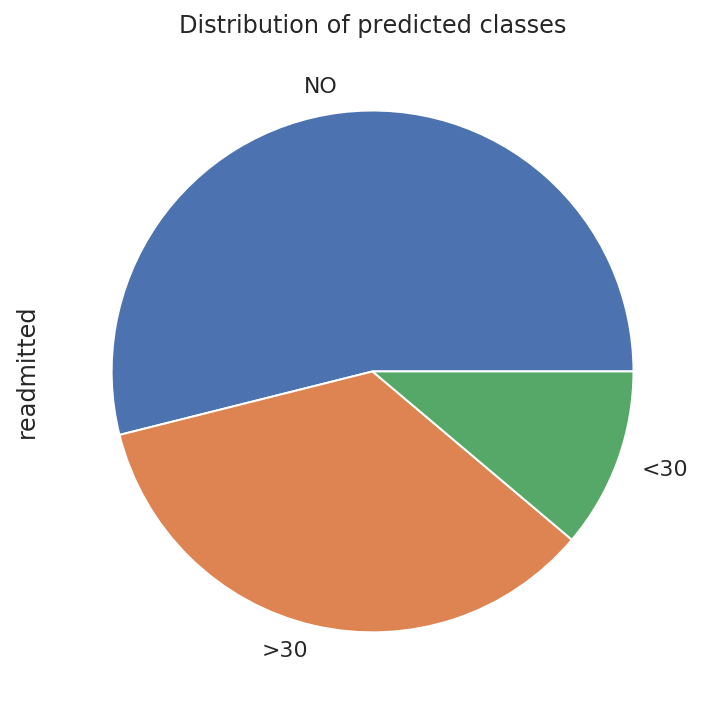

In [11]:
df.readmitted.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [12]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

**Even though the dataset contains 3 classes to be predicted, we transformed our task to binary classification - whether will patient be early readmitted or not (early readmitted is considered if readmission was in < 30 days).**

In [13]:
df['label'] = df.readmitted.apply(lambda x: 1 if x == '<30' else 0)

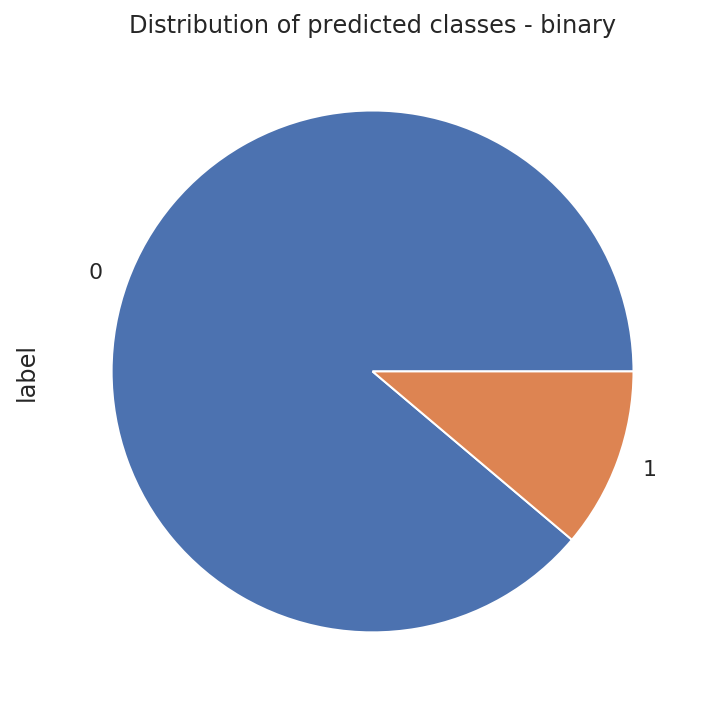

In [14]:
df.label.value_counts().plot(kind='pie', title='Distribution of predicted classes - binary');

In [15]:
df.label.value_counts()

0    90409
1    11357
Name: label, dtype: int64

As we can see, the data are highly imbalanced - just about 10% of the data are in minor positive class. Some methods like oversampling or undersampling should be done later.

### Missing values

From first view of the data, we could see that there are also missing values. We could see also some rows with *None* values, but those values mean that measurement was not done (according to paper that published this dataset [1]). In those cases, *None* value does not represent missing value - information about not performing the measurement can be helpful when predicting patient readmission.

Let's check which columns have missing values and how many (the bar represents the fraction of data that are available - lower the bar, the more missing values are there):

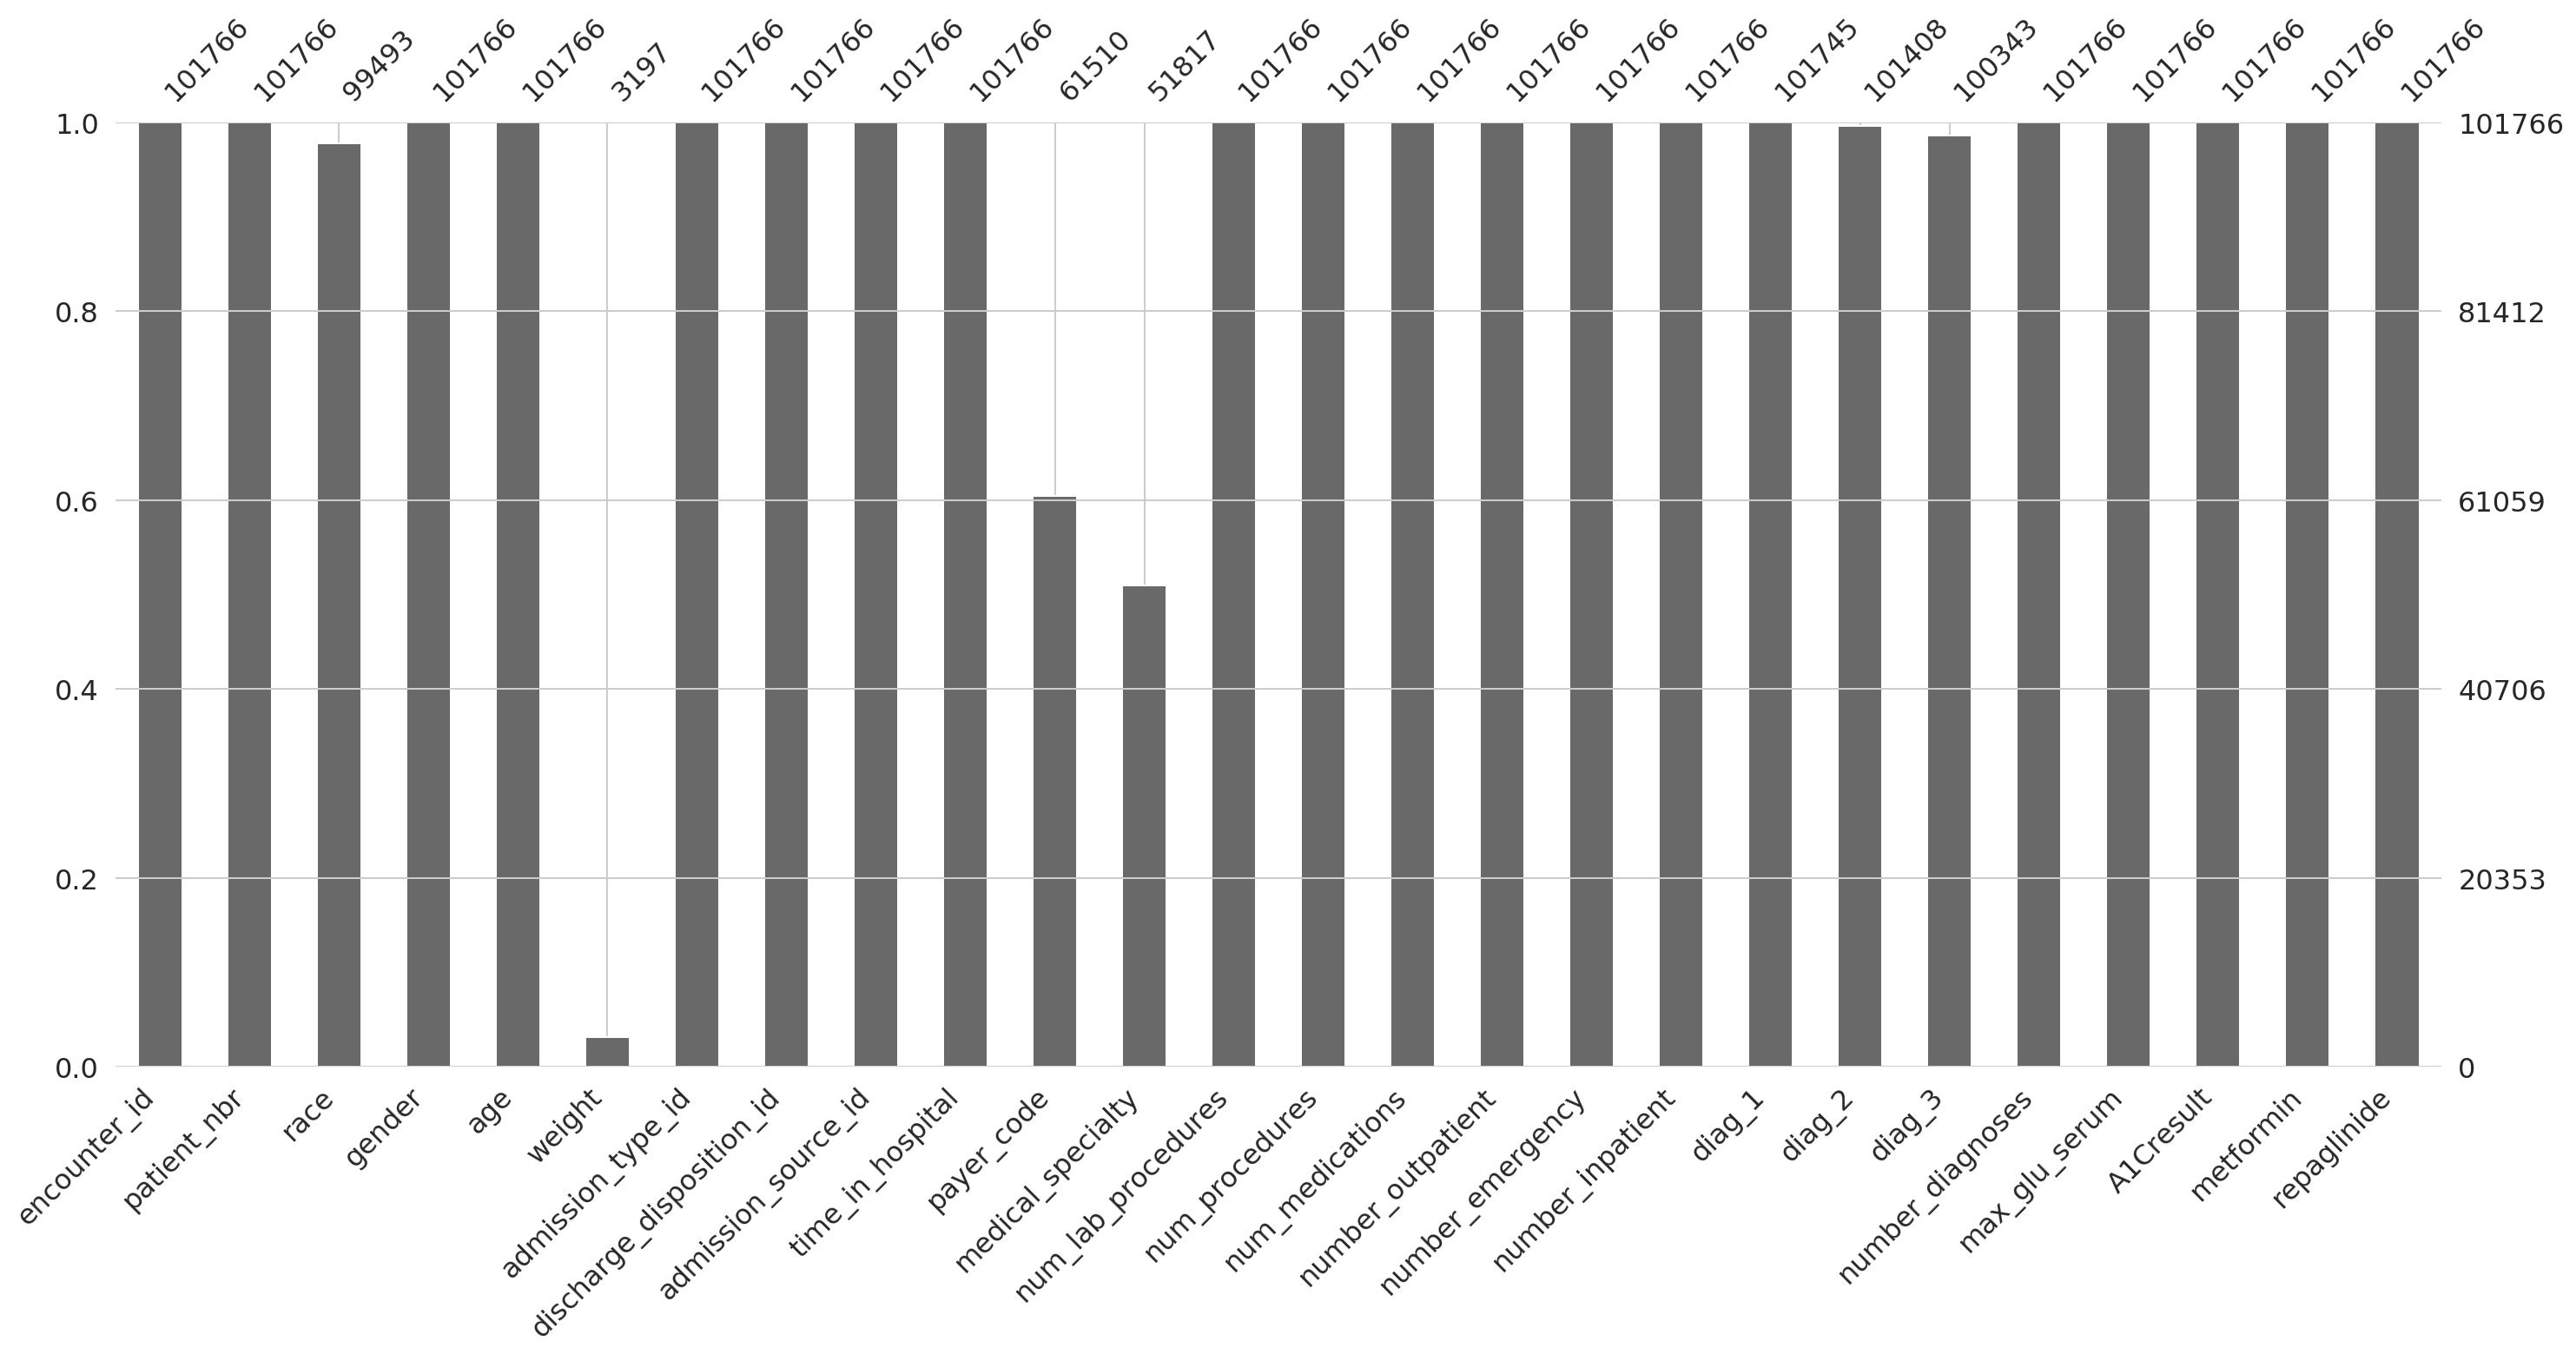

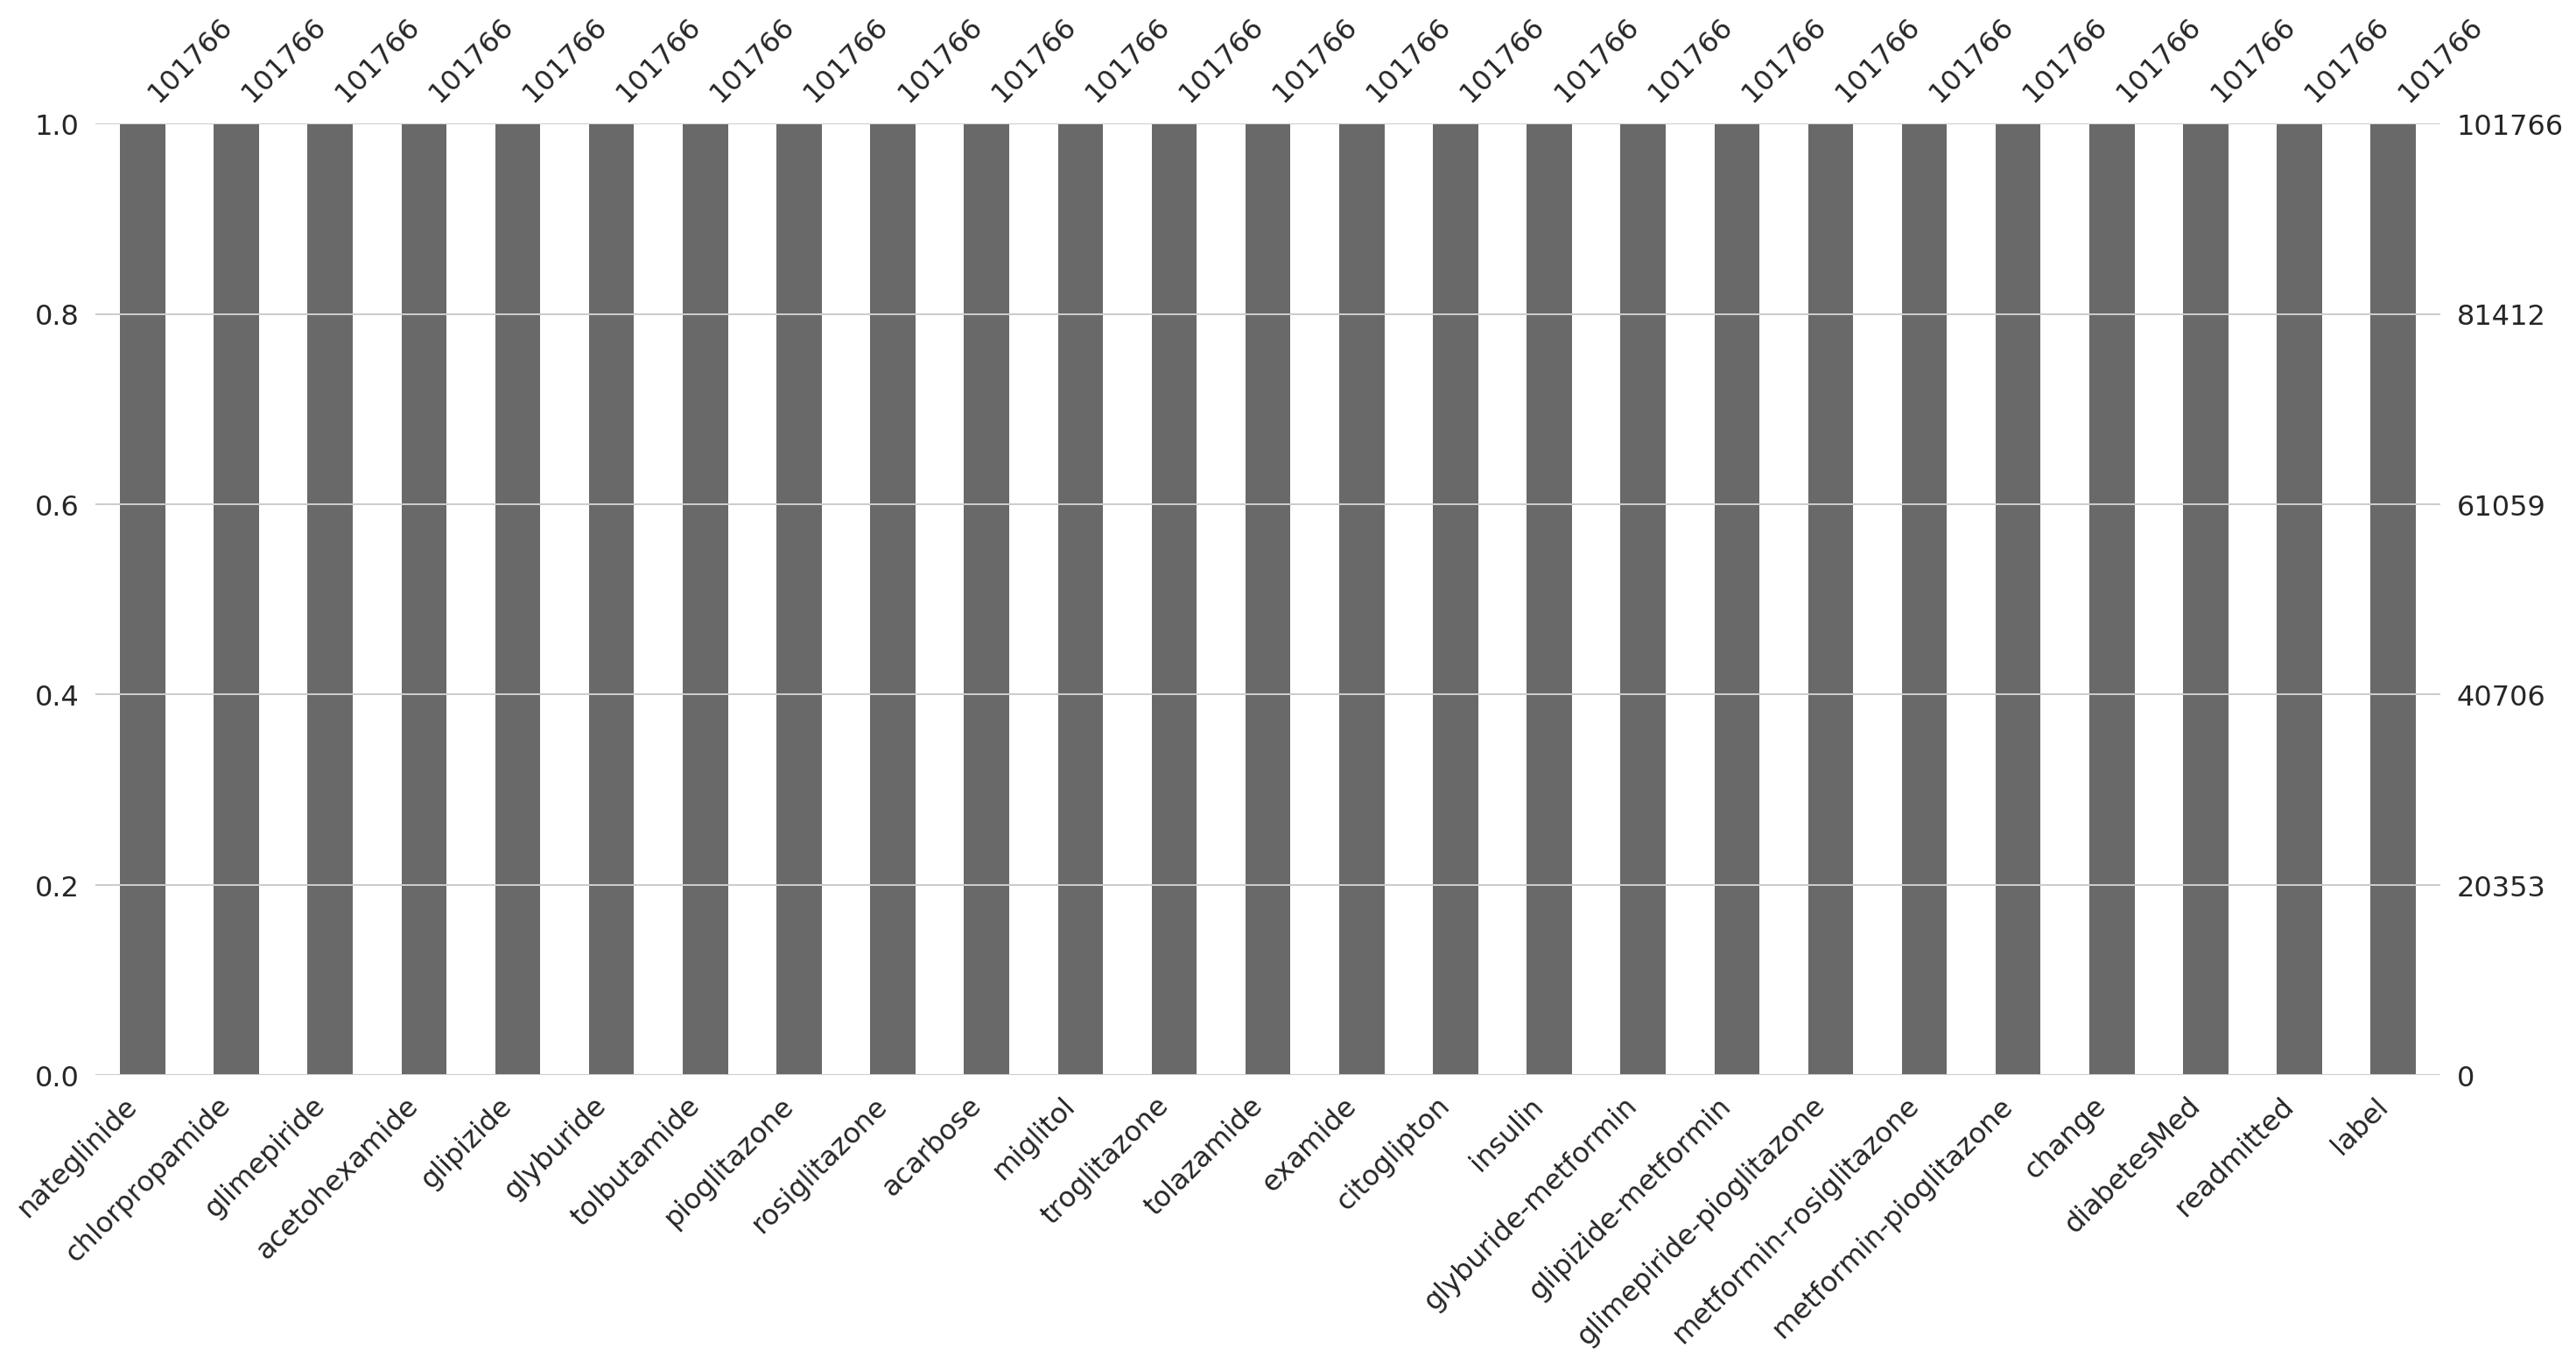

In [16]:
# Divide columns to 2 groups (too many columns for one plot)
column_groups = np.array_split(df.columns, 2)

for columns in column_groups:
    msno.bar(df[columns])
    plt.show()

As we can see, most of the attributes have no missing values. Which attributes have missing values and how many values are missing there?

In [17]:
for column in df.columns:
    missing_count = len(df[column][df[column].isna()])
    missing_percentage = round(missing_count / len(df) * 100, 2)
    if missing_count > 0:
        print(f'{column}: {missing_count} ({missing_percentage}%)')

race: 2273 (2.23%)
weight: 98569 (96.86%)
payer_code: 40256 (39.56%)
medical_specialty: 49949 (49.08%)
diag_1: 21 (0.02%)
diag_2: 358 (0.35%)
diag_3: 1423 (1.4%)


As we can see, only 7 attributes have missing values.

In case of `weight`, `payer_code` and `medical_specialty` would be probably better to drop whole columns and do not use those attributes. The reason is too few values for be able to generalize and fill missing values.

In case of `race`, there are only a few values missing (about 2%), so those values can be filled.

Special case are `diag_1`, `diag_2` and `diag_3` attributes. In this case, we should check whether there are patients with missing values in all of these attributes. If so, those records are probably better to be dropped. Otherwise, values can be filled. Let's check, how many records with missing values in all three attributes are there:

In [18]:
len(df[df.diag_1.isna() & df.diag_2.isna() & df.diag_3.isna()])

1

There is only one that record, so it can be droppend in the preprocessing phase.

### Attributes analysis

In this section, we will analyse all meaningful attributes one by one.

#### Functions definitions

In [19]:
def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Draw barplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data, ax=ax)
    plt.xticks(rotation=ticks_rotation)
    plt.title(title)

    
def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)


def boxplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw boxplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on boxplot.
    :param attribute: name of attribute to be drawn on boxplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)

All the columns that the dataset contains:

In [20]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'label'],
      dtype='object')

There are also some attributes that are not meaningful for our prediction (like `encounter_id` or `patient_nbr`). These attributes will not be analysed.

All attributes will be analysed according to predicted classes (1 and 0, early readmitted or not). In case of categorical attributes, plots are showing normalized percentage of values because of unbalanced classes.

**Not all plots/results have the description or explanation. Explanations were skipped in cases, where not significant or interesting conclusions were found. Usefulness of those attributes will be shown in later phases (prediction and feature selection).**

**NOTE:** All the descriptions of attributes are inspired or taken from original paper [1].

#### race

Race of patient. 

Values:
* `Caucasian`,
* `Asian`,
* `African`,
* `American`,
* `Hispanic`,
* `other`.

In [21]:
df.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

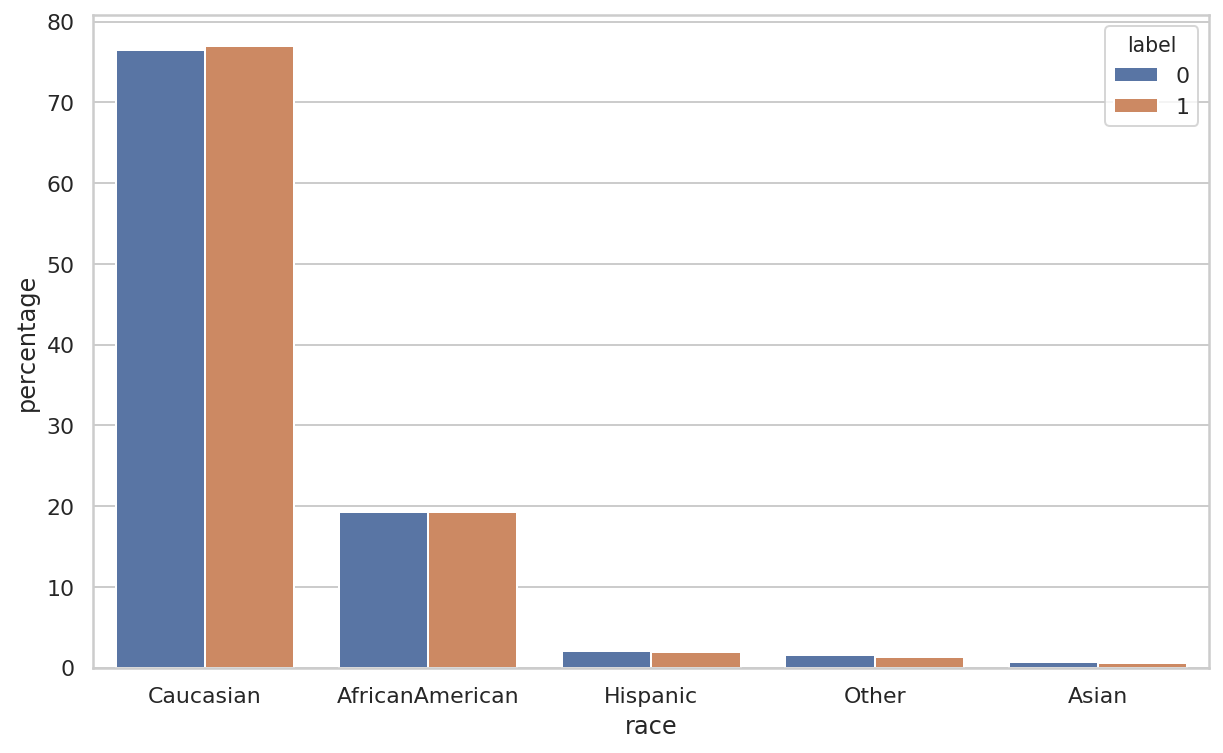

In [22]:
barplot_per_classes(df, 'race', 'label')

#### gender

Gender of patient.

In [23]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

As we can see, there are also 3 values that are *unknown/invalid*. Those 3 values should be changed to *male*/*female*, just like when NaN values are filled.

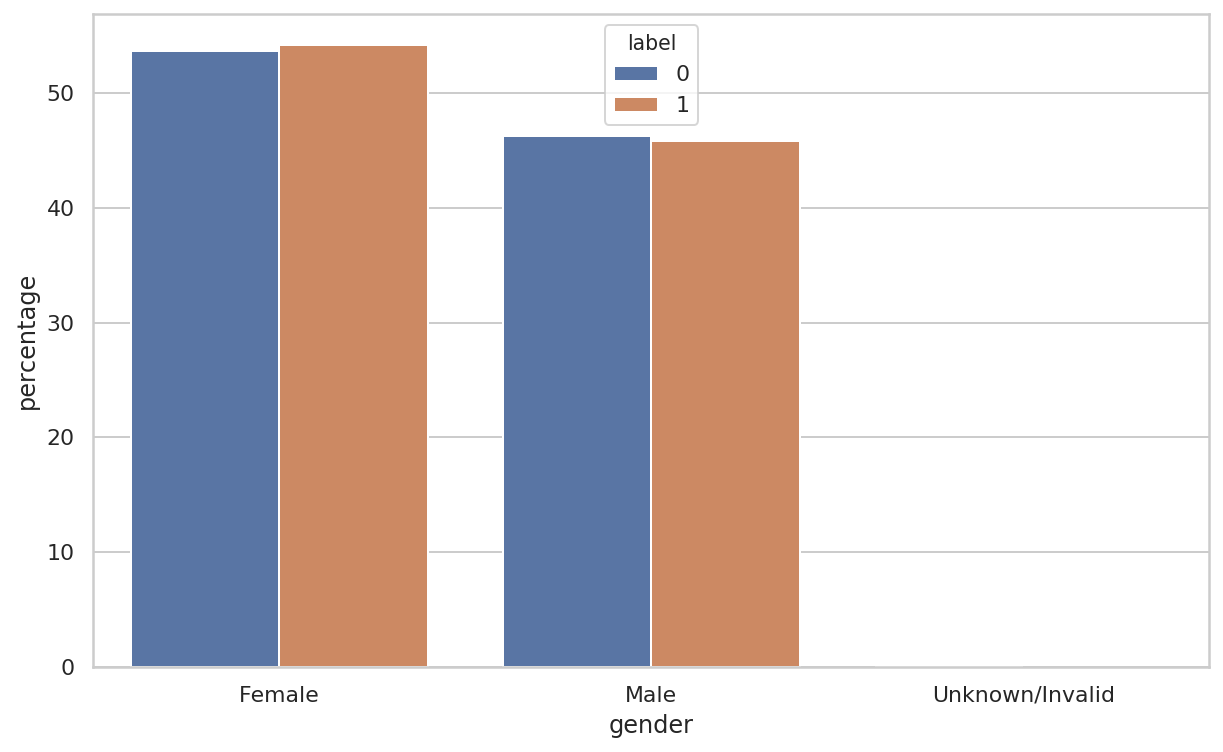

In [24]:
barplot_per_classes(df, 'gender', 'label')

#### age

Age of patient. Grouped in 10-years intervals: [0,10), [10,20), ..., [90,100).

In [25]:
df.age.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

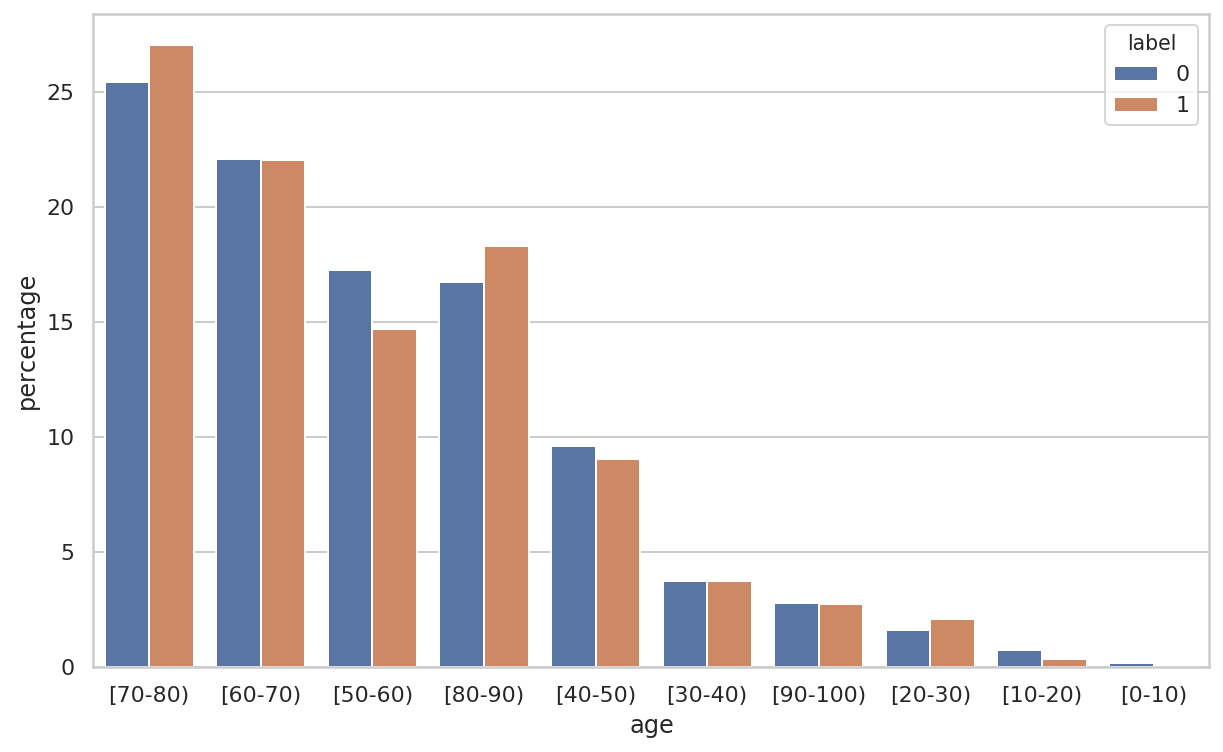

In [26]:
barplot_per_classes(df, 'age', 'label')

From `age` feature we can see that majority of patients have higher age. Also, we can observe a trend of rising number of early readmitted patients with higher age. Age can be one of the factors for early readmission.

Let's try to convert age interval into middle value to get numerical representation and check boxplot:

In [27]:
def convert_age(age):
    """
    Convert age from interval into middle value.
    
    :return: middle value of age interval.
    """
    age = age[1:-1]
    lower_boundary = int(age.split('-')[0])
    upper_boundary = int(age.split('-')[1])
    return (upper_boundary + lower_boundary) / 2

In [28]:
df['age_middle_value'] = df['age'].apply(lambda x: convert_age(x))

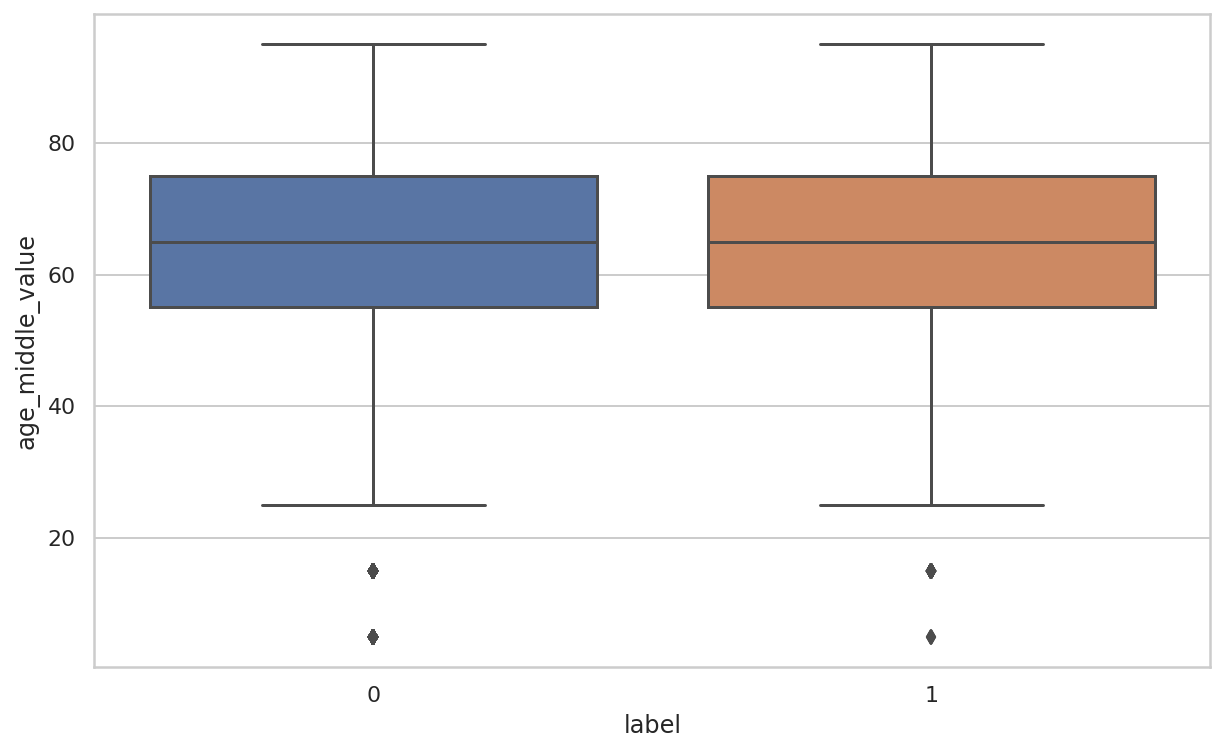

In [29]:
boxplot_per_classes(df, 'age_middle_value', 'label')

From the boxplot, we can see that there is only a minor difference at first sight.

#### weight

Weight of patient in pounds. Grouped in 25 pounds intervals.

As we have already mentioned before, this column has almost everywhere missing values. We will rather drop it in preprocessing phase.

In [30]:
df.weight.value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

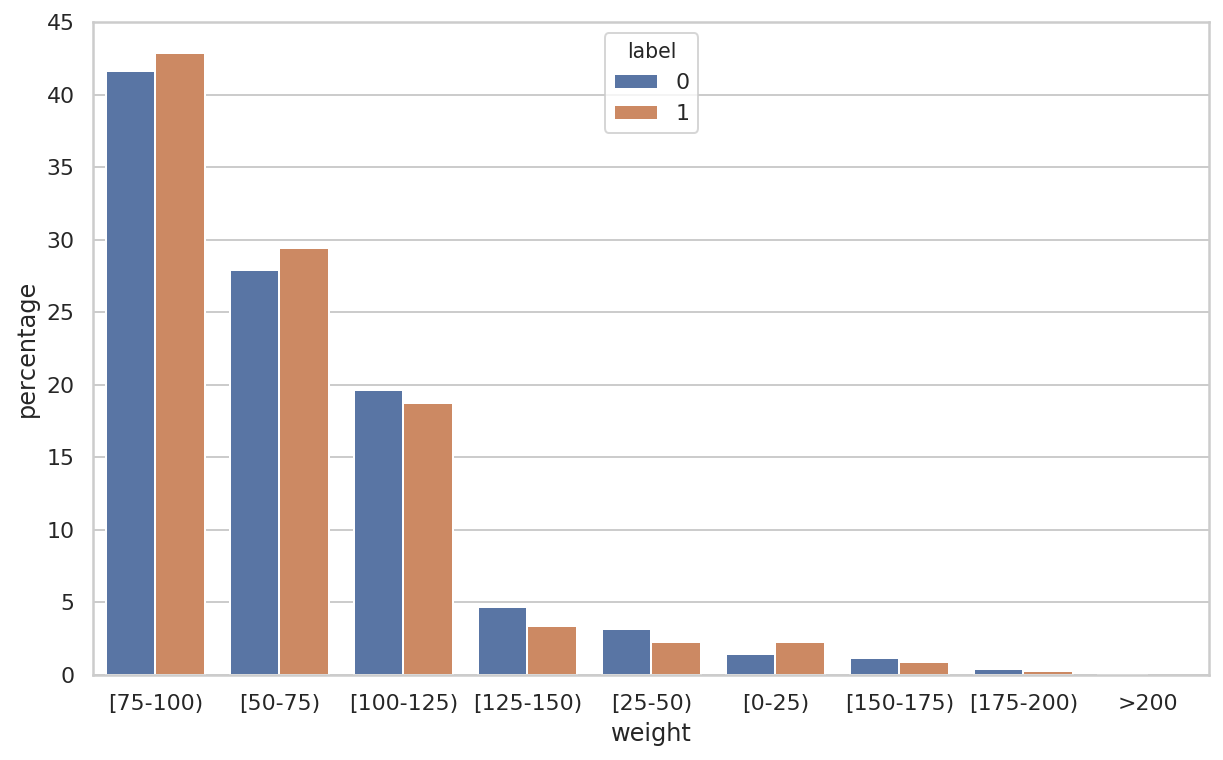

In [31]:
barplot_per_classes(df, 'weight', 'label')

#### admission_type_id

Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available.

In [32]:
df.admission_type_id.value_counts()

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

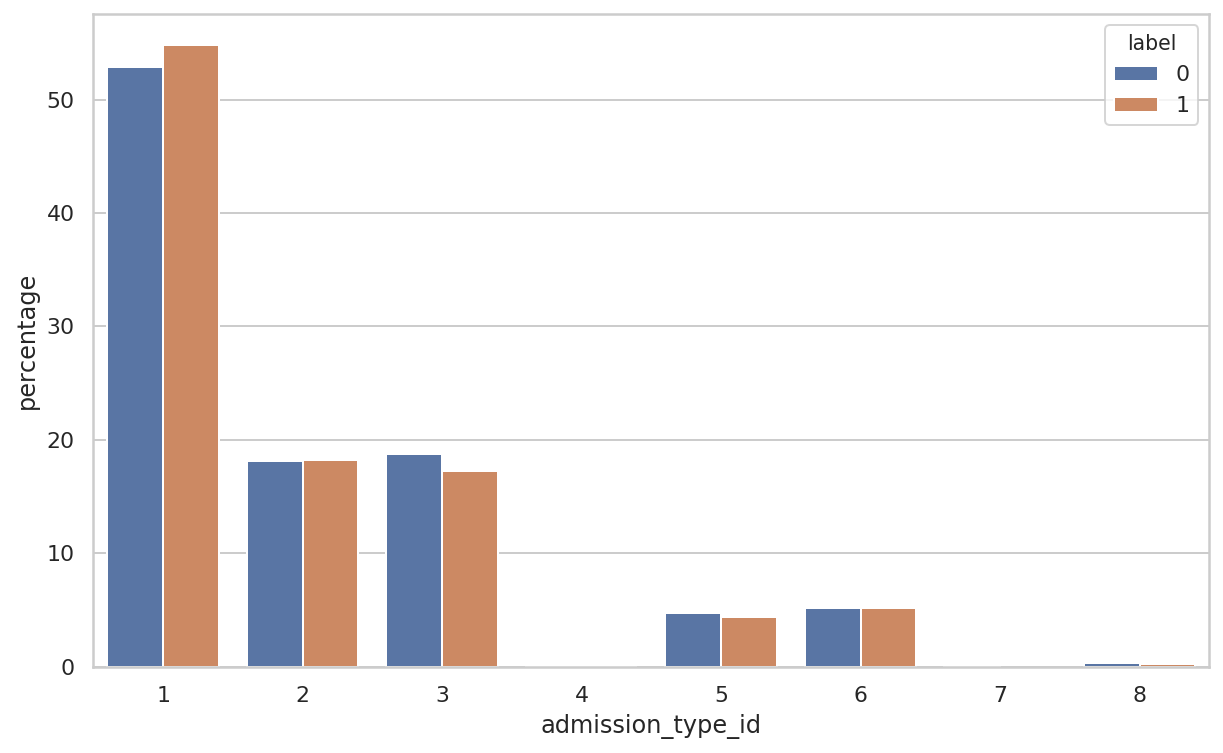

In [33]:
barplot_per_classes(df, 'admission_type_id', 'label')

#### discharge_disposition_id

Itenger identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.

In [34]:
df.discharge_disposition_id.value_counts()

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

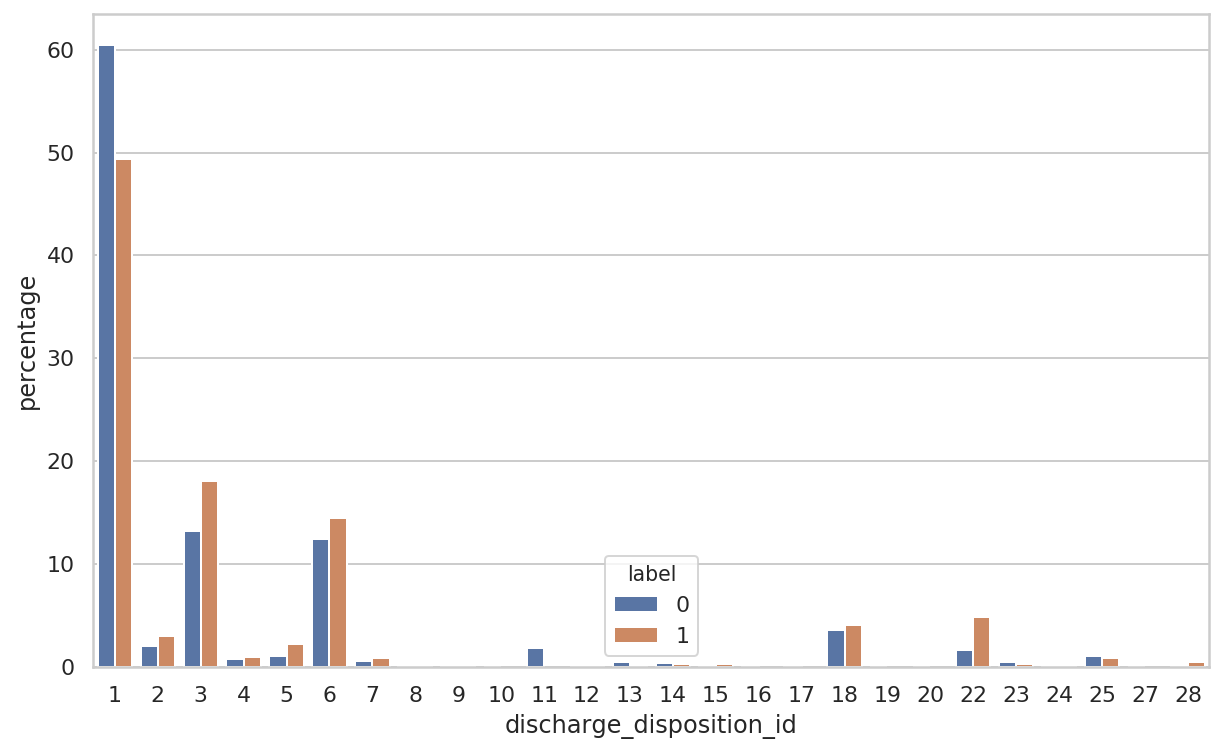

In [35]:
barplot_per_classes(df, 'discharge_disposition_id', 'label')

We don't know meaning of each value for discharge disposition but we can see diferences between classes for each value. This feature can help in further data mining.

#### admission_source_id

Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from hospital.

In [36]:
df.admission_source_id.value_counts()

7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

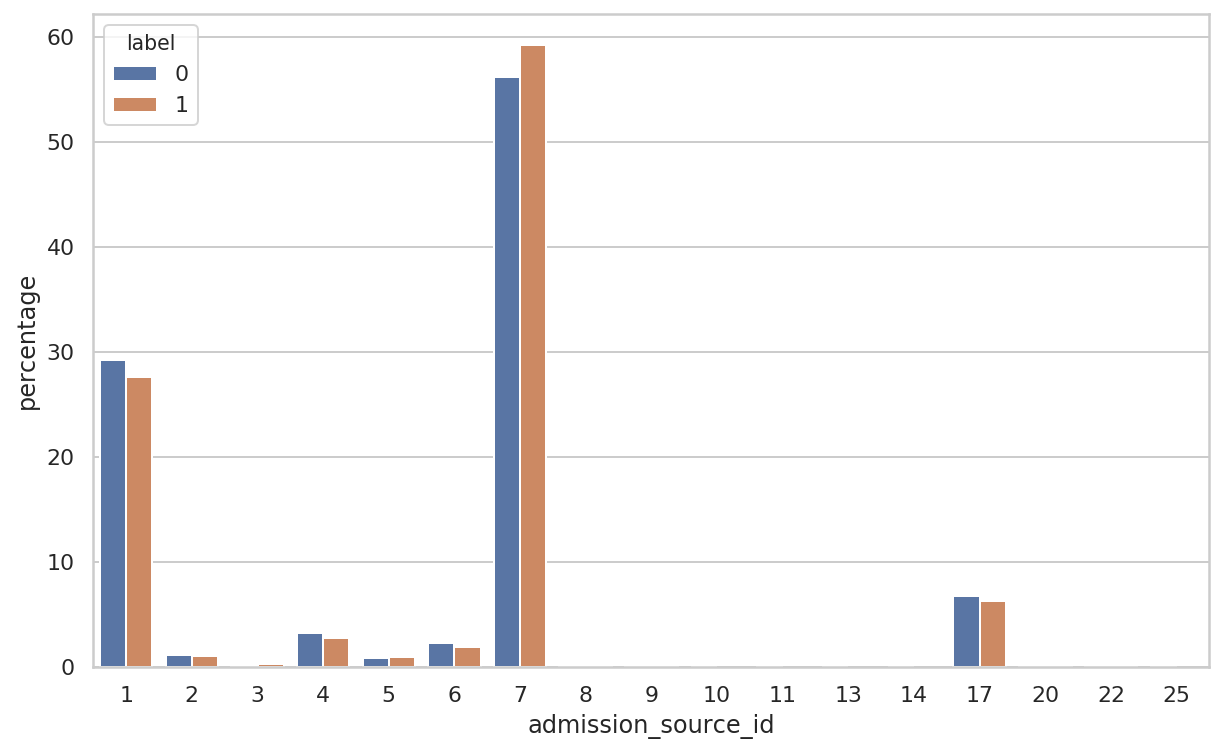

In [37]:
barplot_per_classes(df, 'admission_source_id', 'label')

#### time_in_hospital

Integer number of days between admission and discharge.

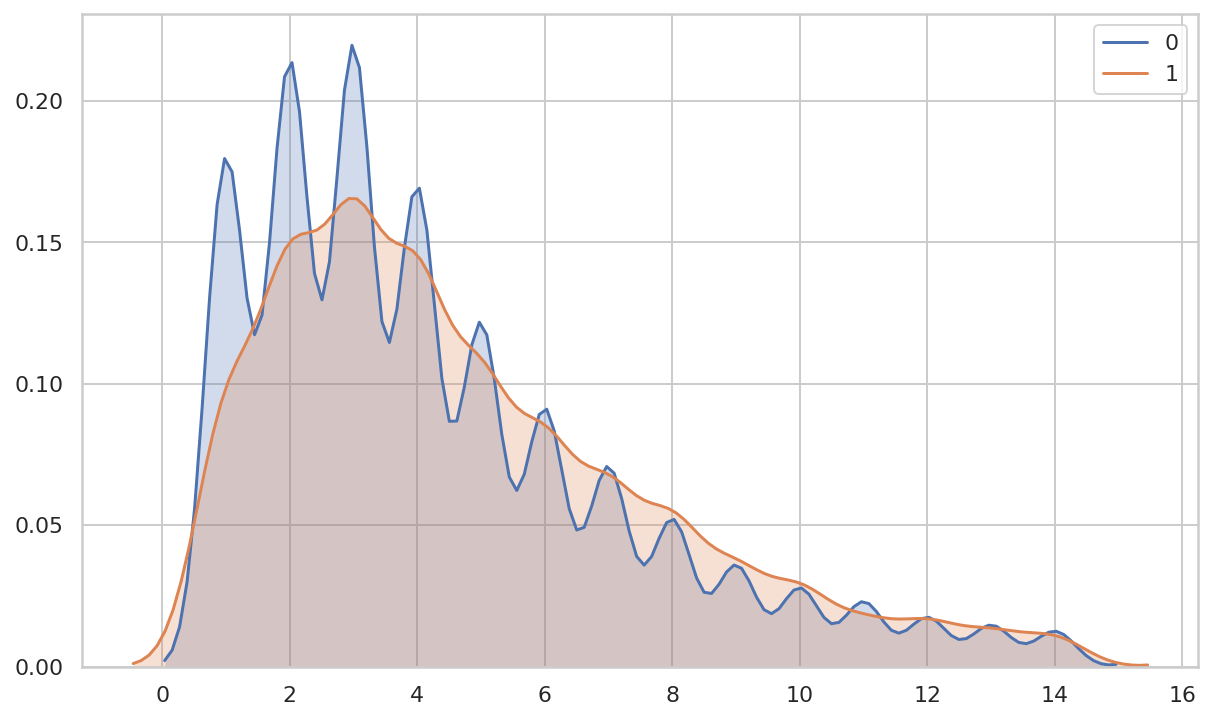

In [38]:
kdeplot_per_classes(df, 'time_in_hospital', 'label')

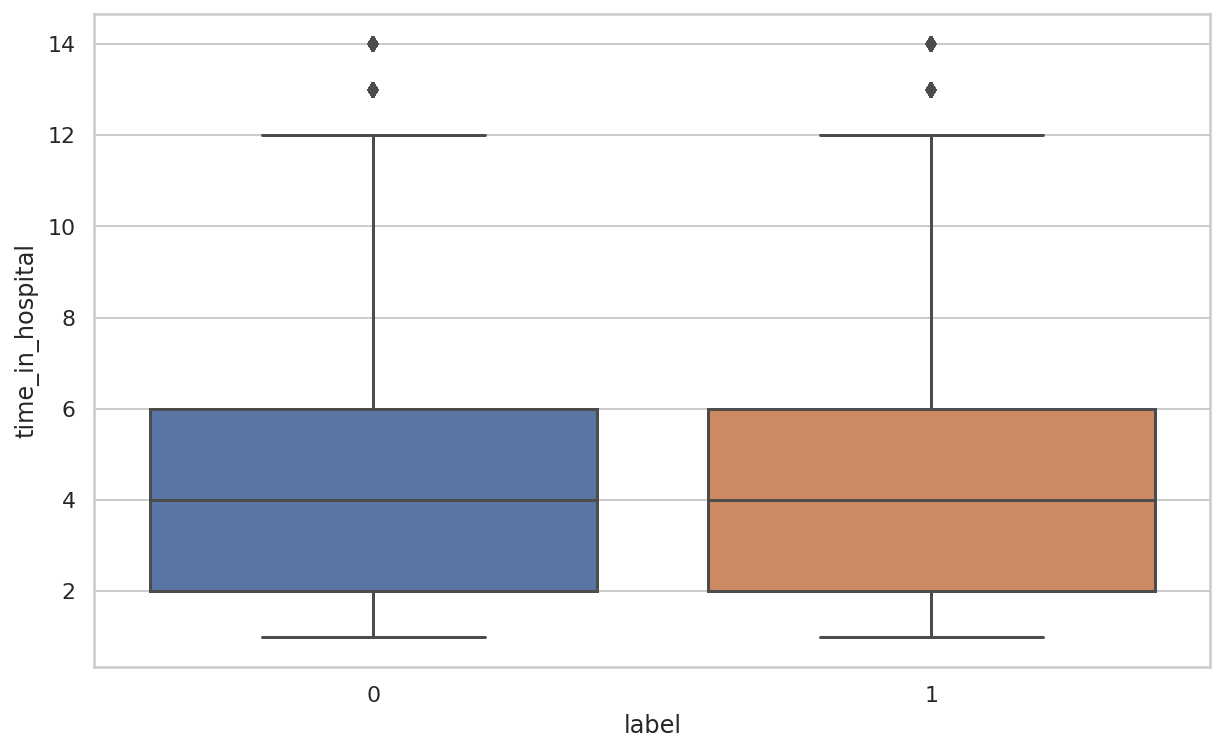

In [39]:
boxplot_per_classes(df, 'time_in_hospital', 'label')

#### payer_code

Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay.

Even if the attribute can be useful in prediction, it can be caused by an accident - naturally, the way how the treatment is payed has no cause to patient readmission (but only if the treatment is not dependent on insurance company).

In previous analysis, we have found out that a lot of values are missing. Those values still can be filled/completed, but as mentioned above, this attribute may not influence whether patient will be readmitted or not. In this case, probably better way will be to drop the attribute.

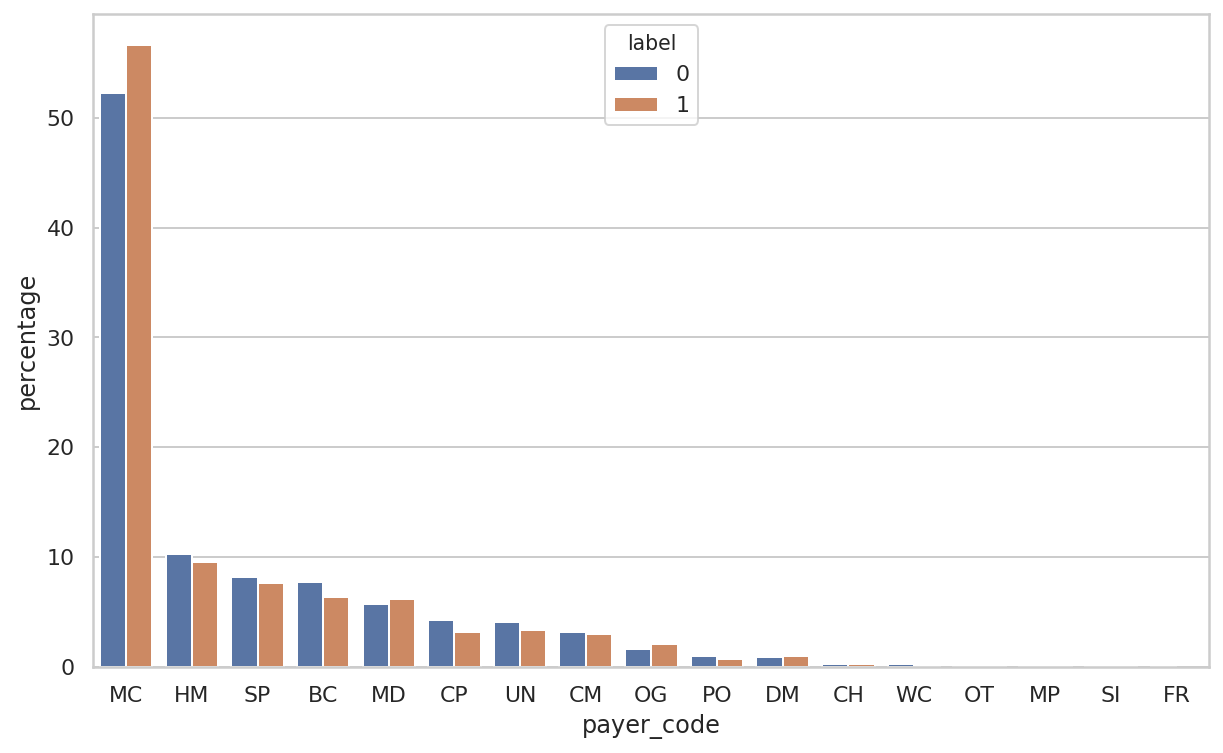

In [40]:
barplot_per_classes(df, 'payer_code', 'label')

#### medical_specialty

Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon.

As there are a lot of distinct values (84), we will only check top 10:

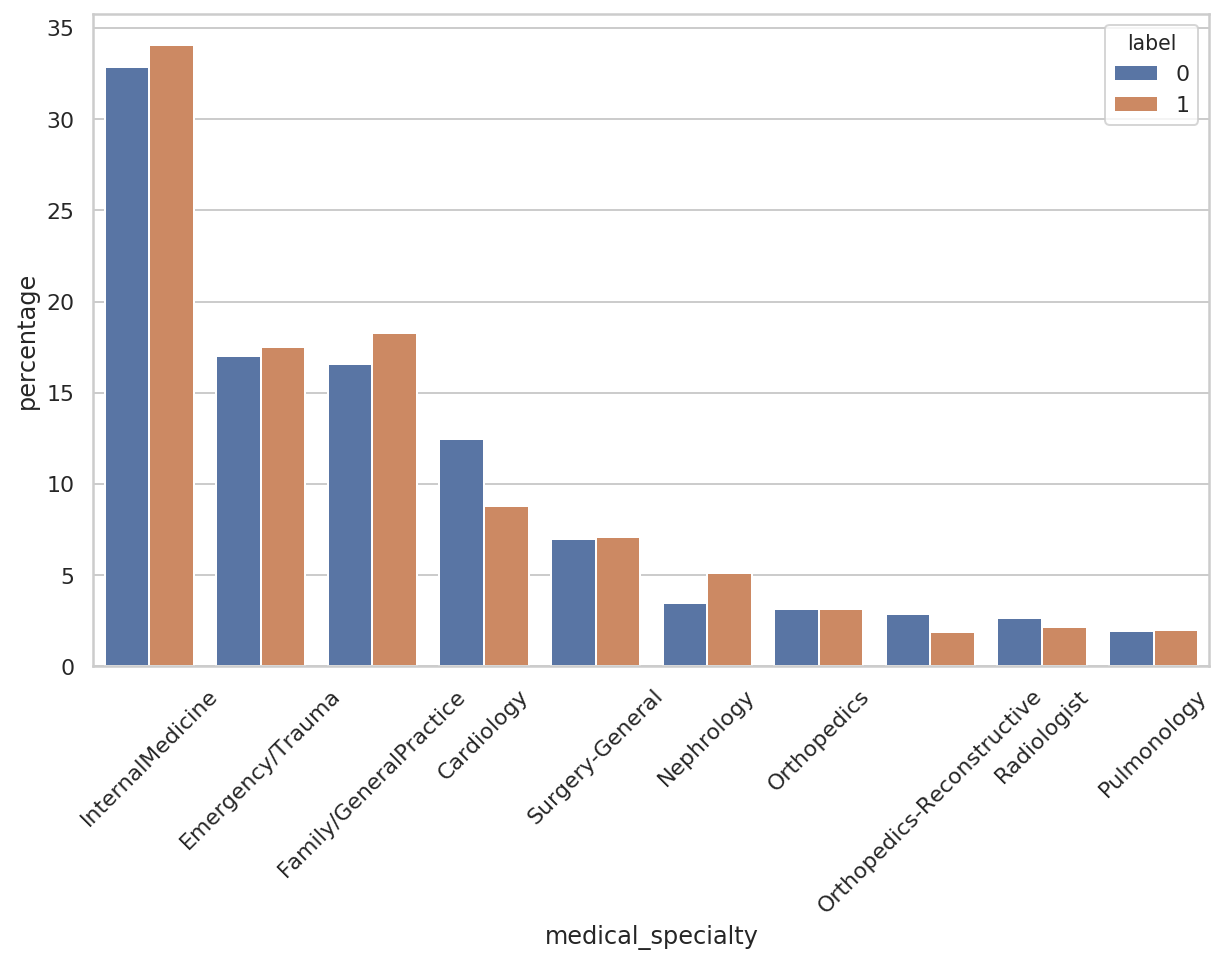

In [41]:
barplot_per_classes(df, 'medical_specialty', 'label', ticks_rotation=45, topn=10)

#### num_lab_procedures

Number of lab tests performed during the encounter.

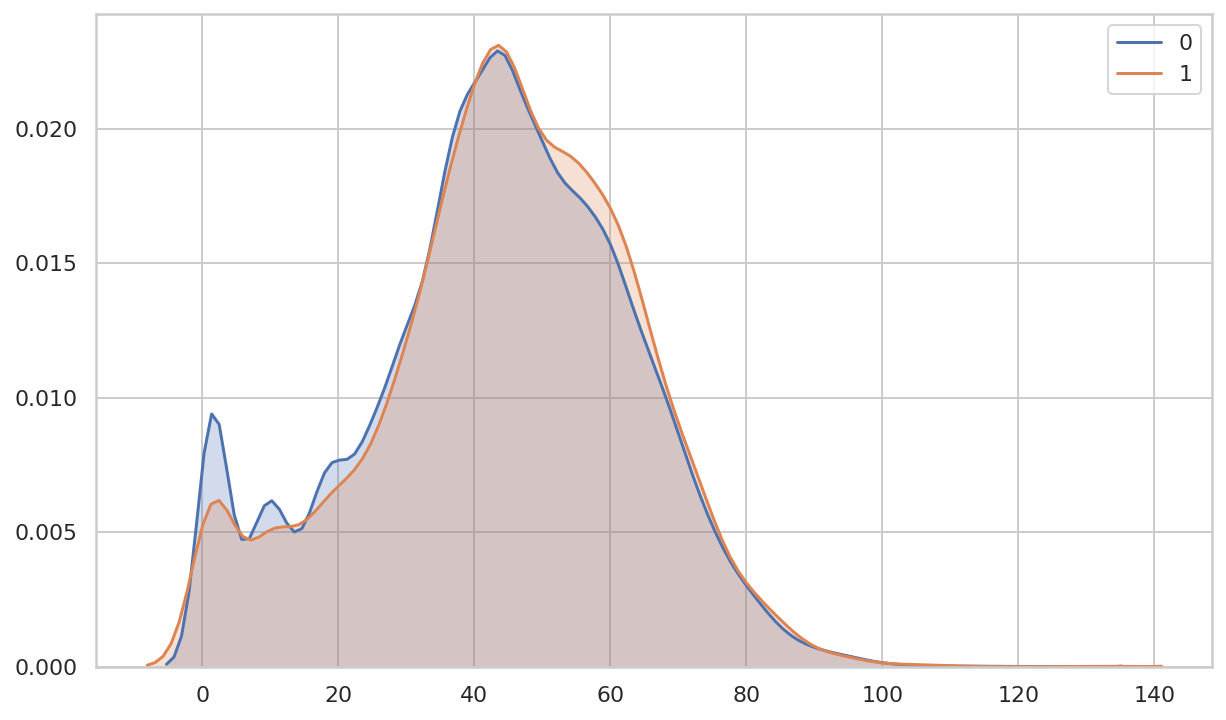

In [42]:
kdeplot_per_classes(df, 'num_lab_procedures', 'label')

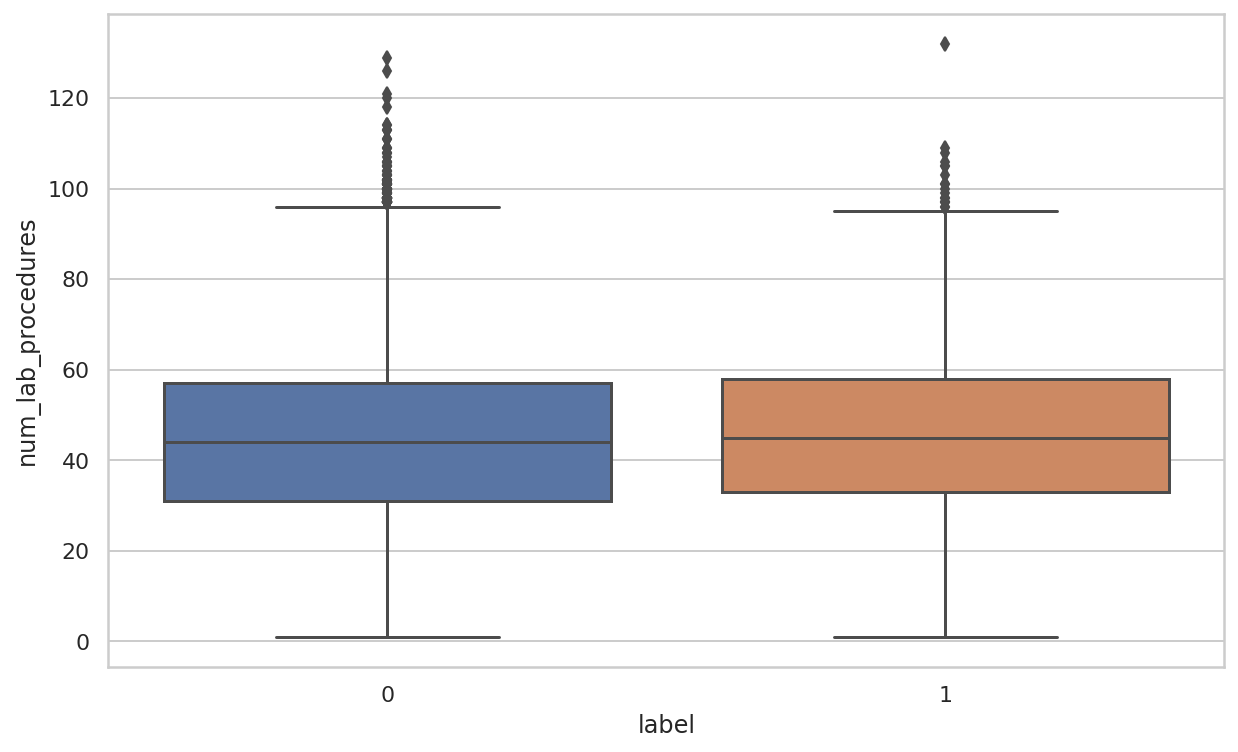

In [43]:
boxplot_per_classes(df, 'num_lab_procedures', 'label')

#### num_procedures

Number of procedures (other than lab tests) performed during the encounter.

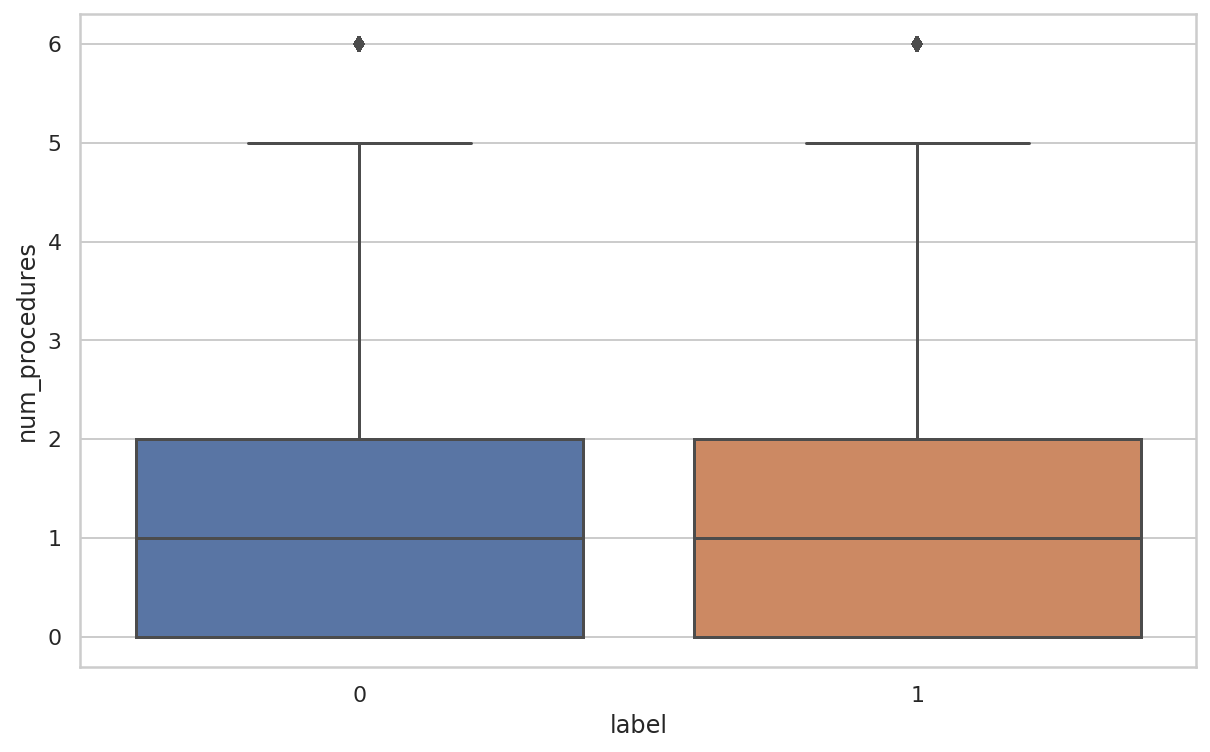

In [44]:
boxplot_per_classes(df, 'num_procedures', 'label')

#### num_medications

Number of distinct generic names administered during the encounter.

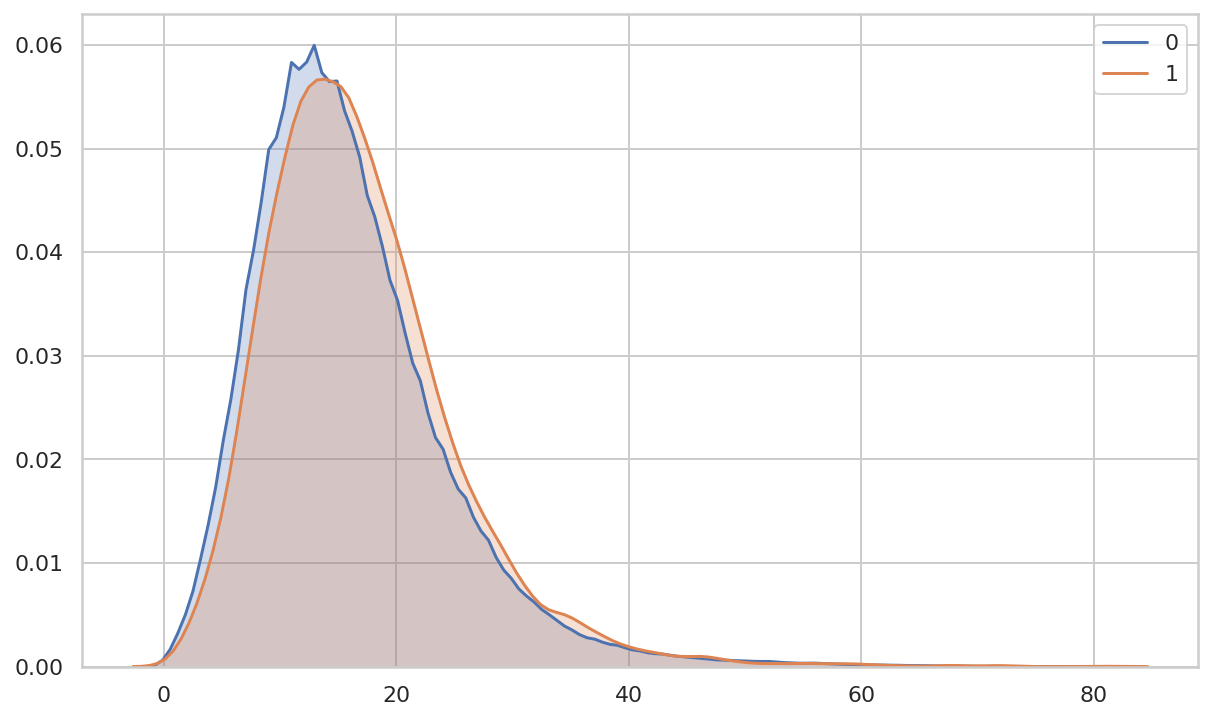

In [45]:
kdeplot_per_classes(df, 'num_medications', 'label')

#### number_outpatient

Number of outpatient visits of the patient in the year preceding the encounter.

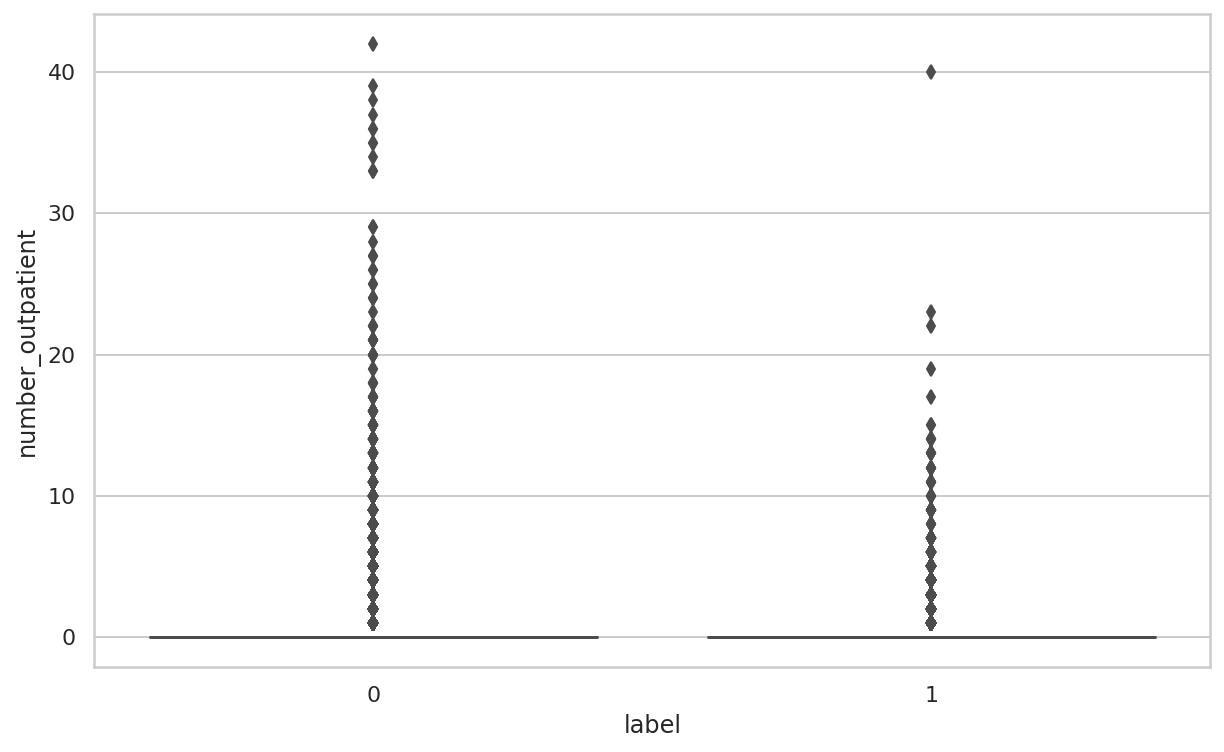

In [46]:
boxplot_per_classes(df, 'number_outpatient', 'label')

As we can see, most of records have value equal to 0. How many percent of all records have visits equal to 0?

In [47]:
print(f'{round(len(df[df.number_outpatient == 0]) / len(df) * 100, 2)}%')

83.55%


It is quite a lot. From this point of view, it is hard to say whether it would be useful for prediction or not.

#### number_emergency

Number of emergency visits of the patient in the year preceding the encounter.

This attribute is very similar to the previous one (`number_outpatient`).

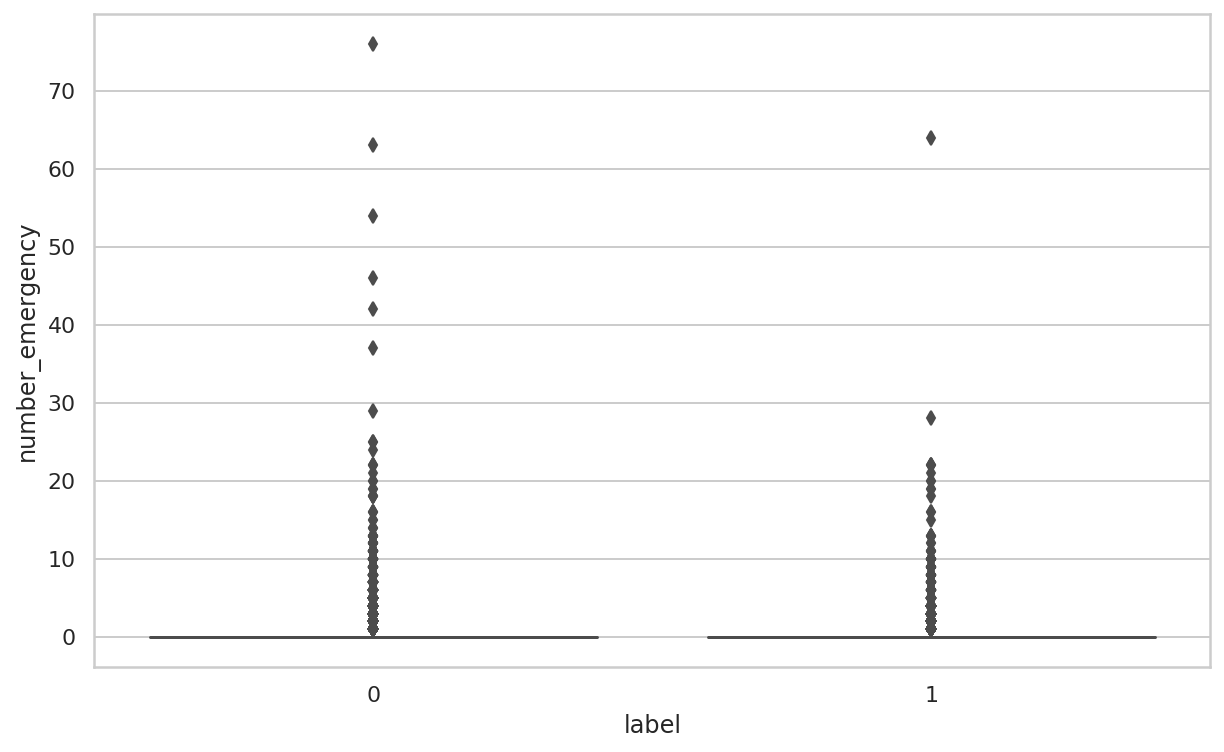

In [48]:
boxplot_per_classes(df, 'number_emergency', 'label')

Again, a lot of values are equal to 0. How many percent is that?

In [49]:
print(f'{round(len(df[df.number_emergency == 0]) / len(df) * 100, 2)}%')

88.81%


This attribute is very similar to previous one and has even more values equal to 0. Again, it is hard to say whether it will be useful for prediction.

#### number_inpatient

Number of inpatient visits of the patient in the year preceding the encounter.

Similar to two previous attributes.

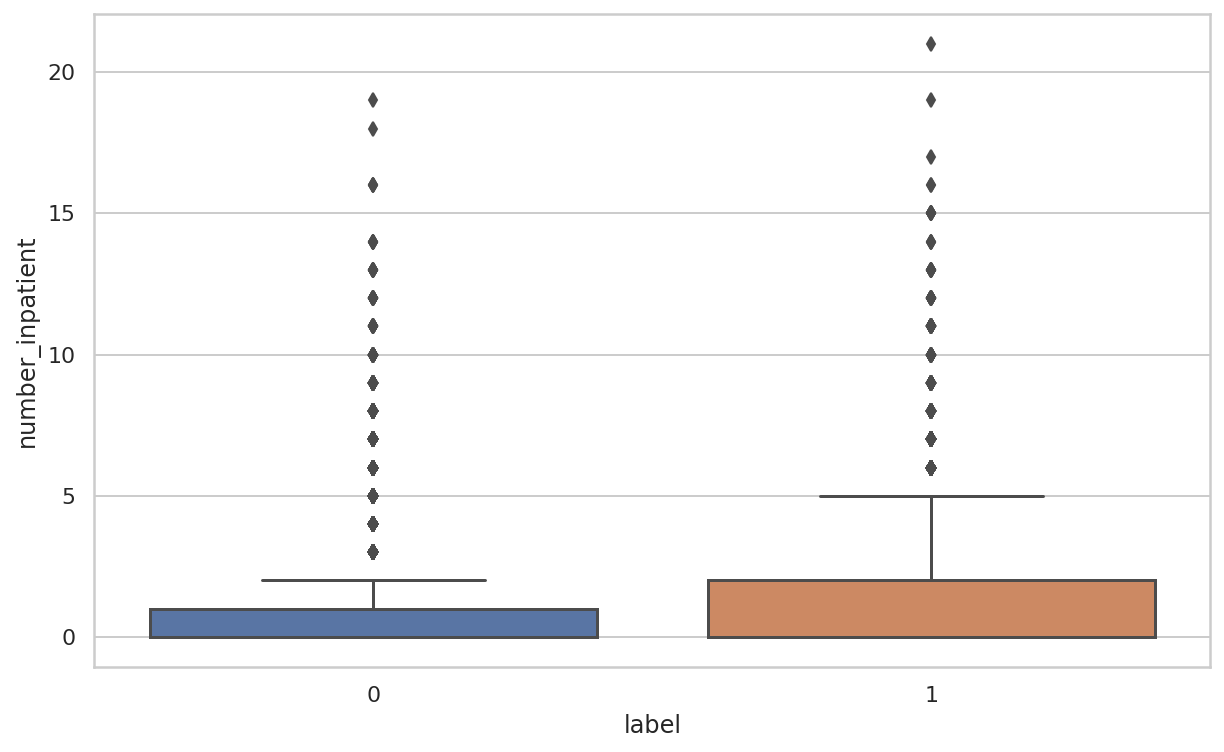

In [50]:
boxplot_per_classes(df, 'number_inpatient', 'label')

#### diagnosis
Columns `diag_1`, `diag_2` and `diag_3` are codes for one of the type of diagnose. Here we need create mapping where diagnosis code is mapped to categorical value. We used rules from paper [1] to map more than 700 unique code values to 9 groups of diagnosis.

Let's check how many of unique values are there for each attribute (they can overlap of course):

In [51]:
len(df.diag_1.unique()), len(df.diag_2.unique()), len(df.diag_3.unique())

(717, 749, 790)

In [52]:
def diagnosis_mapping():
    """
    Create code to diagnosis mappings.
    
    :return: dictionary with mappings.
    """
    mapping = {}
    mapping['circulatory'] = list(range(390,460)) + [785]
    mapping['respiratory'] = list(range(460,520)) + [786]
    mapping['digestive'] = list(range(520,580)) + [787]
    mapping['diabetes'] = [250]
    mapping['injury'] = list(range(800,1000))
    mapping['musculoskeletal'] = list(range(710,740))
    mapping['genitourinary'] = list(range(580,630)) + [788]
    mapping['neoplasm'] = list(range(140,240))
    
    all_codes =  reduce(lambda x, y: x + mapping[y], mapping.keys(), [])
    mapping['other'] = [x for x in range(1,1000) if x not in all_codes]
    mapping['other'] = mapping['other'] + list(string.ascii_uppercase)
    
    for key in mapping.keys():
        mapping[key] = [str(x) for x in mapping[key]]
    return mapping

In [53]:
def map_code_to_diagnose(code, mapping):
    """
    Map code to diagnose.
    
    :return: diagnose according to given code.
    """
    code = str(code)
    if not code:
        return None
    for diagnose in mapping.keys():
        if diagnose in ['diabetes', 'other']:
            if any([code.startswith(x) for x in mapping[diagnose]]):
                return diagnose
            else:
                continue
        if code in mapping[diagnose]:
            return diagnose    

In [54]:
mapping = diagnosis_mapping()
df['diag_1_category'] = df.diag_1.apply(lambda x: map_code_to_diagnose(x, mapping))
df['diag_2_category'] = df.diag_2.apply(lambda x: map_code_to_diagnose(x, mapping))
df['diag_3_category'] = df.diag_3.apply(lambda x: map_code_to_diagnose(x, mapping))

#### diag_1
The primary diagnosis (coded as first three digits of ICD9); possibly 848 distinct values.

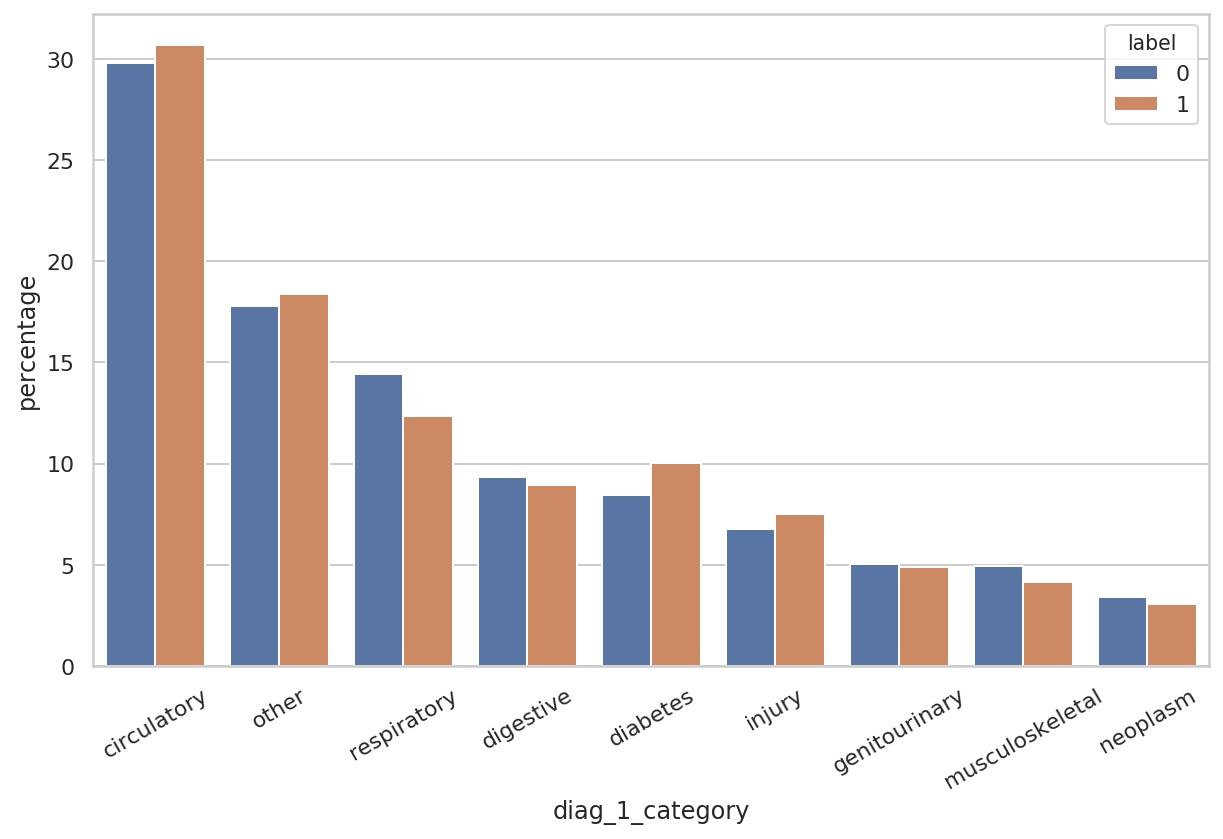

In [55]:
barplot_per_classes(df, 'diag_1_category', 'label', ticks_rotation=30)

Let's check most common codes per diagnosis category. Plots are showing categories `circulatory`, `other`, `respiratory`, `diabetes`, `digestive`, `injury`, `musculoskeletal`, `genitourinary`, `neoplasm` from left to right, from top to bottom:

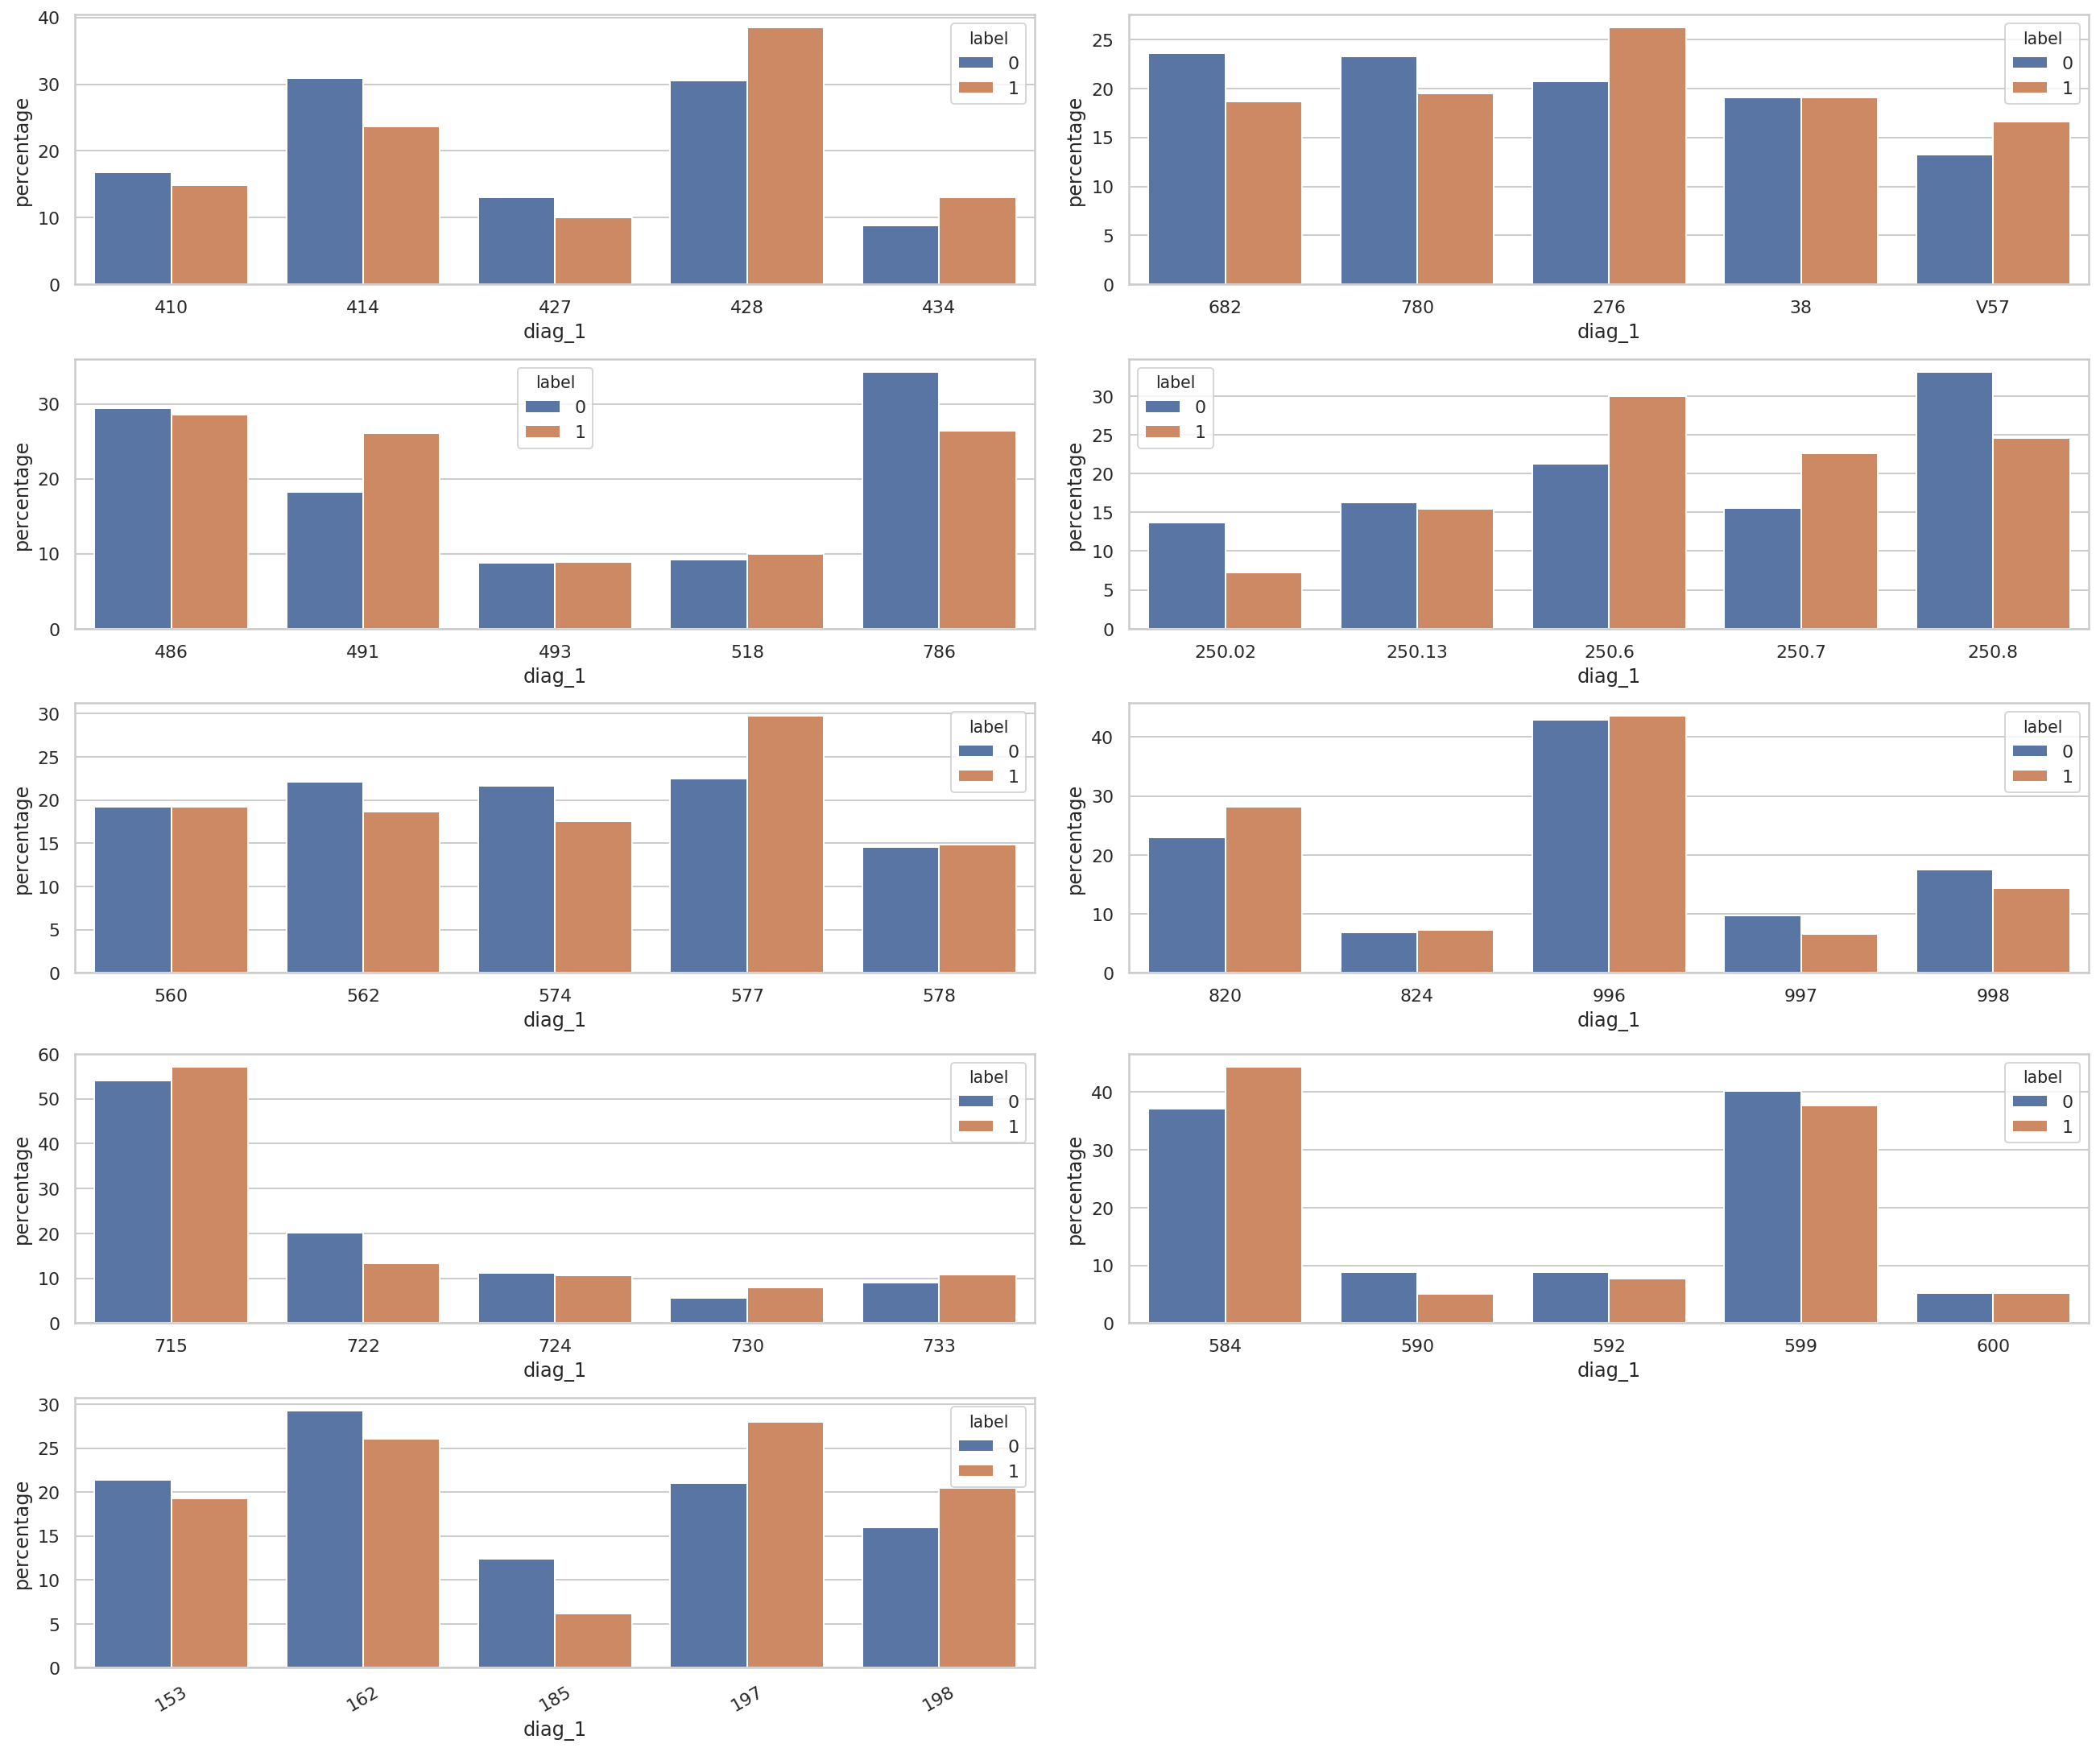

In [56]:
fig, axs = plt.subplots(nrows=5, ncols=2, constrained_layout=True)
fig.delaxes(axs[4,1])
fig.set_size_inches(18, 15)

barplot_per_classes(df[df['diag_1_category'] == 'circulatory'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[0][0])
barplot_per_classes(df[df['diag_1_category'] == 'other'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[0][1])

barplot_per_classes(df[df['diag_1_category'] == 'respiratory'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[1][0])
barplot_per_classes(df[df['diag_1_category'] == 'diabetes'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[1][1])

barplot_per_classes(df[df['diag_1_category'] == 'digestive'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[2][0])
barplot_per_classes(df[df['diag_1_category'] == 'injury'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[2][1])

barplot_per_classes(df[df['diag_1_category'] == 'musculoskeletal'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[3][0])
barplot_per_classes(df[df['diag_1_category'] == 'genitourinary'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[3][1])

barplot_per_classes(df[df['diag_1_category'] == 'neoplasm'], 'diag_1', 'label',
                    ticks_rotation=30, topn=5, ax=axs[4][0])

Those plots are just informative, because probably only diagnosis categories will be used for prediction. Plot of most commont codes per diagnosis category will not be shown for next two attributes `diag_2` and `diag_3`.

#### diag_2

Secondary diagnosis (coded as first three digits of ICD9); possibly 923 distinct values.

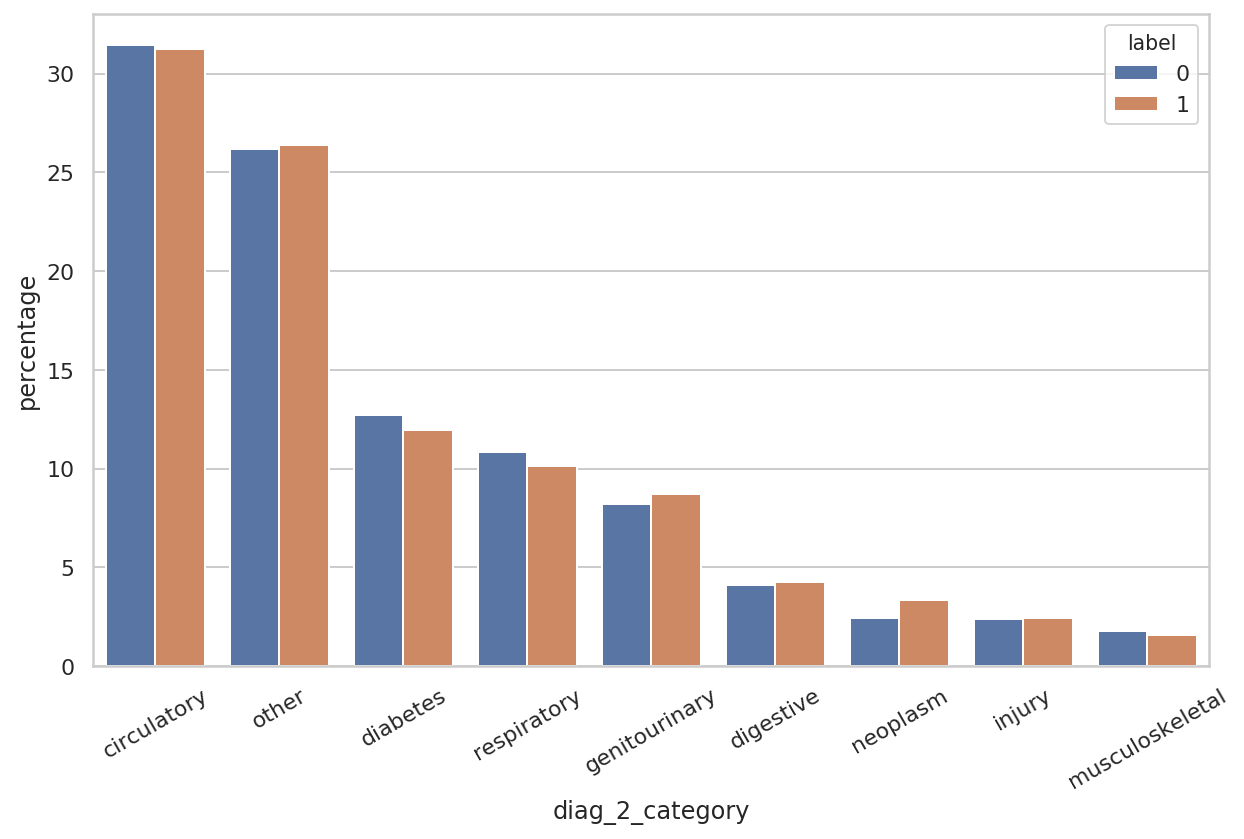

In [57]:
barplot_per_classes(df, 'diag_2_category', 'label', ticks_rotation=30)

#### diag_3

Additional secondary diagnosis (coded as first three digits of ICD9); possibly 954 distinct values.

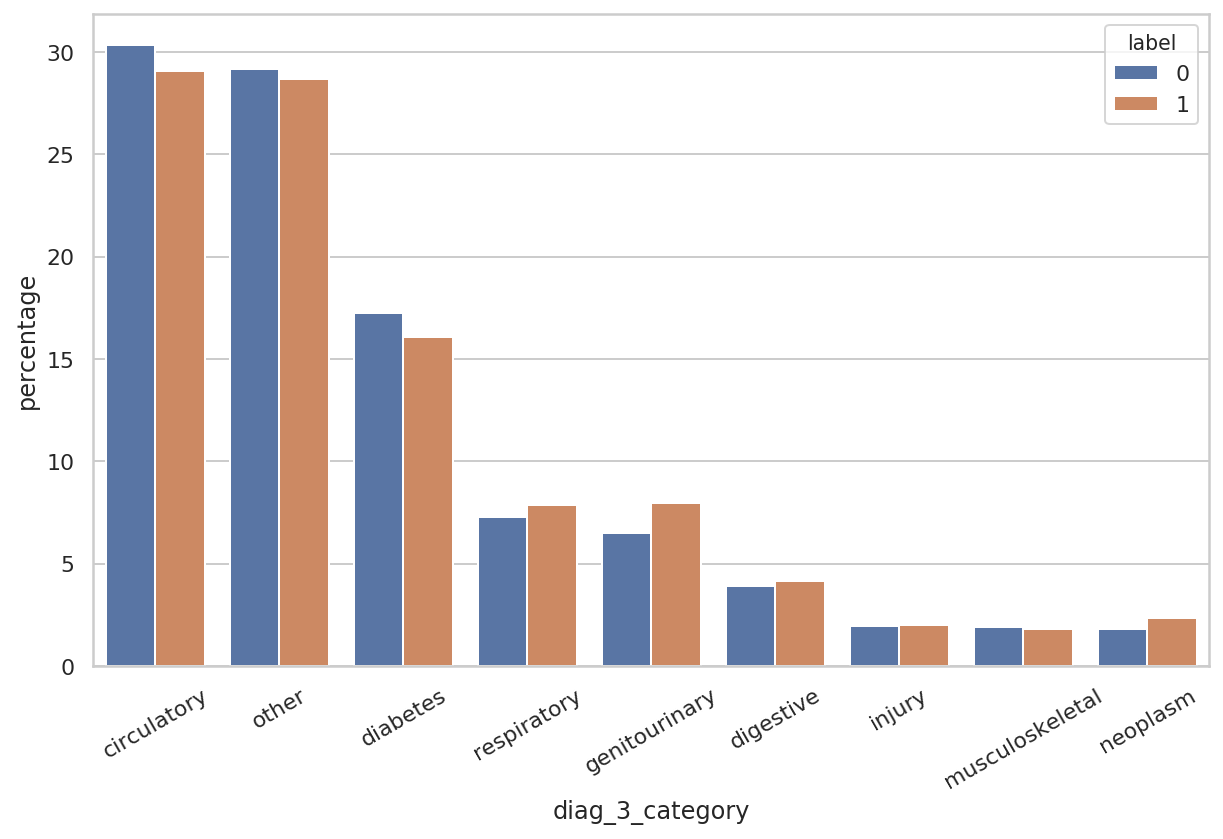

In [58]:
barplot_per_classes(df, 'diag_3_category', 'label', ticks_rotation=30)

#### number_diagnoses

Number of diagnoses entered to the system.

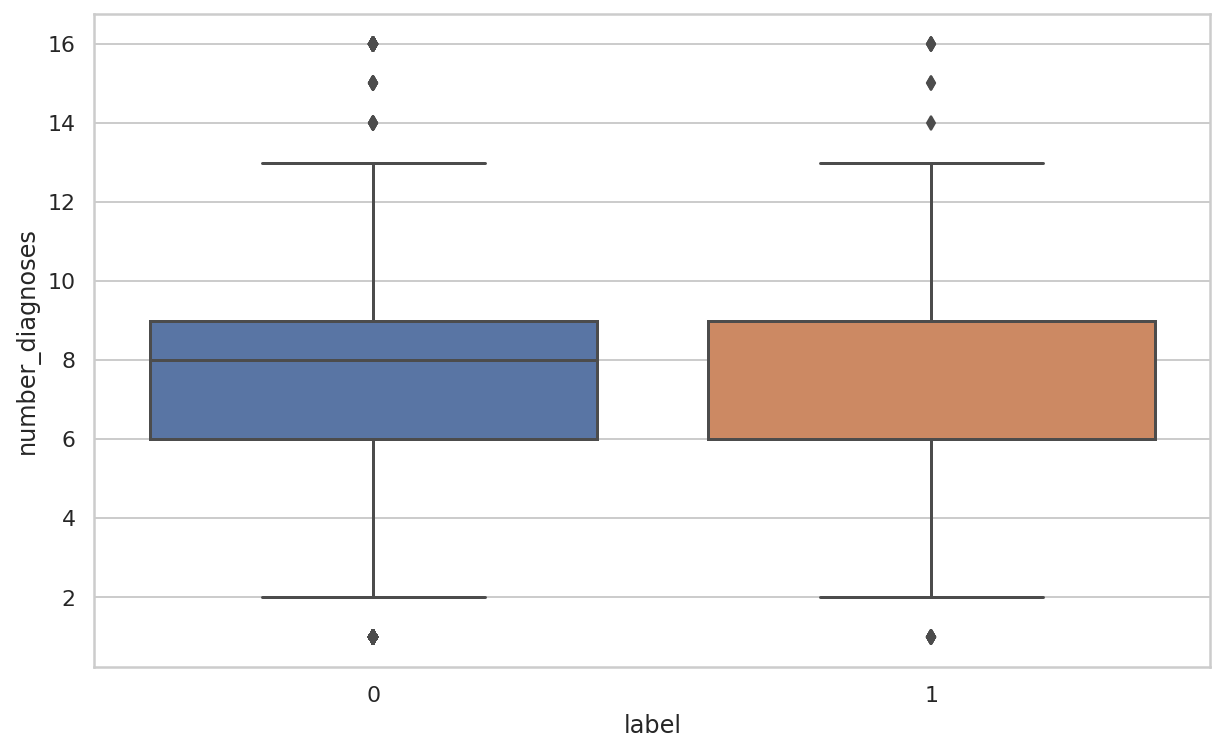

In [59]:
boxplot_per_classes(df, 'number_diagnoses','label')

#### Medicaments - 23 attributes

For the generic names: **metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone**, the feature indicates whether the drug was prescribed or there was a change in the dosage.

Values: 
* `up` if the dosage was increased during the encounter, 
* `down` if the dosage was decreased, 
* `steady` if the dosage did not change, 
* `no` if the drug was not prescribed.

All of those attributes will be analysed together:

In [60]:
all_medicaments = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide','glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin','glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

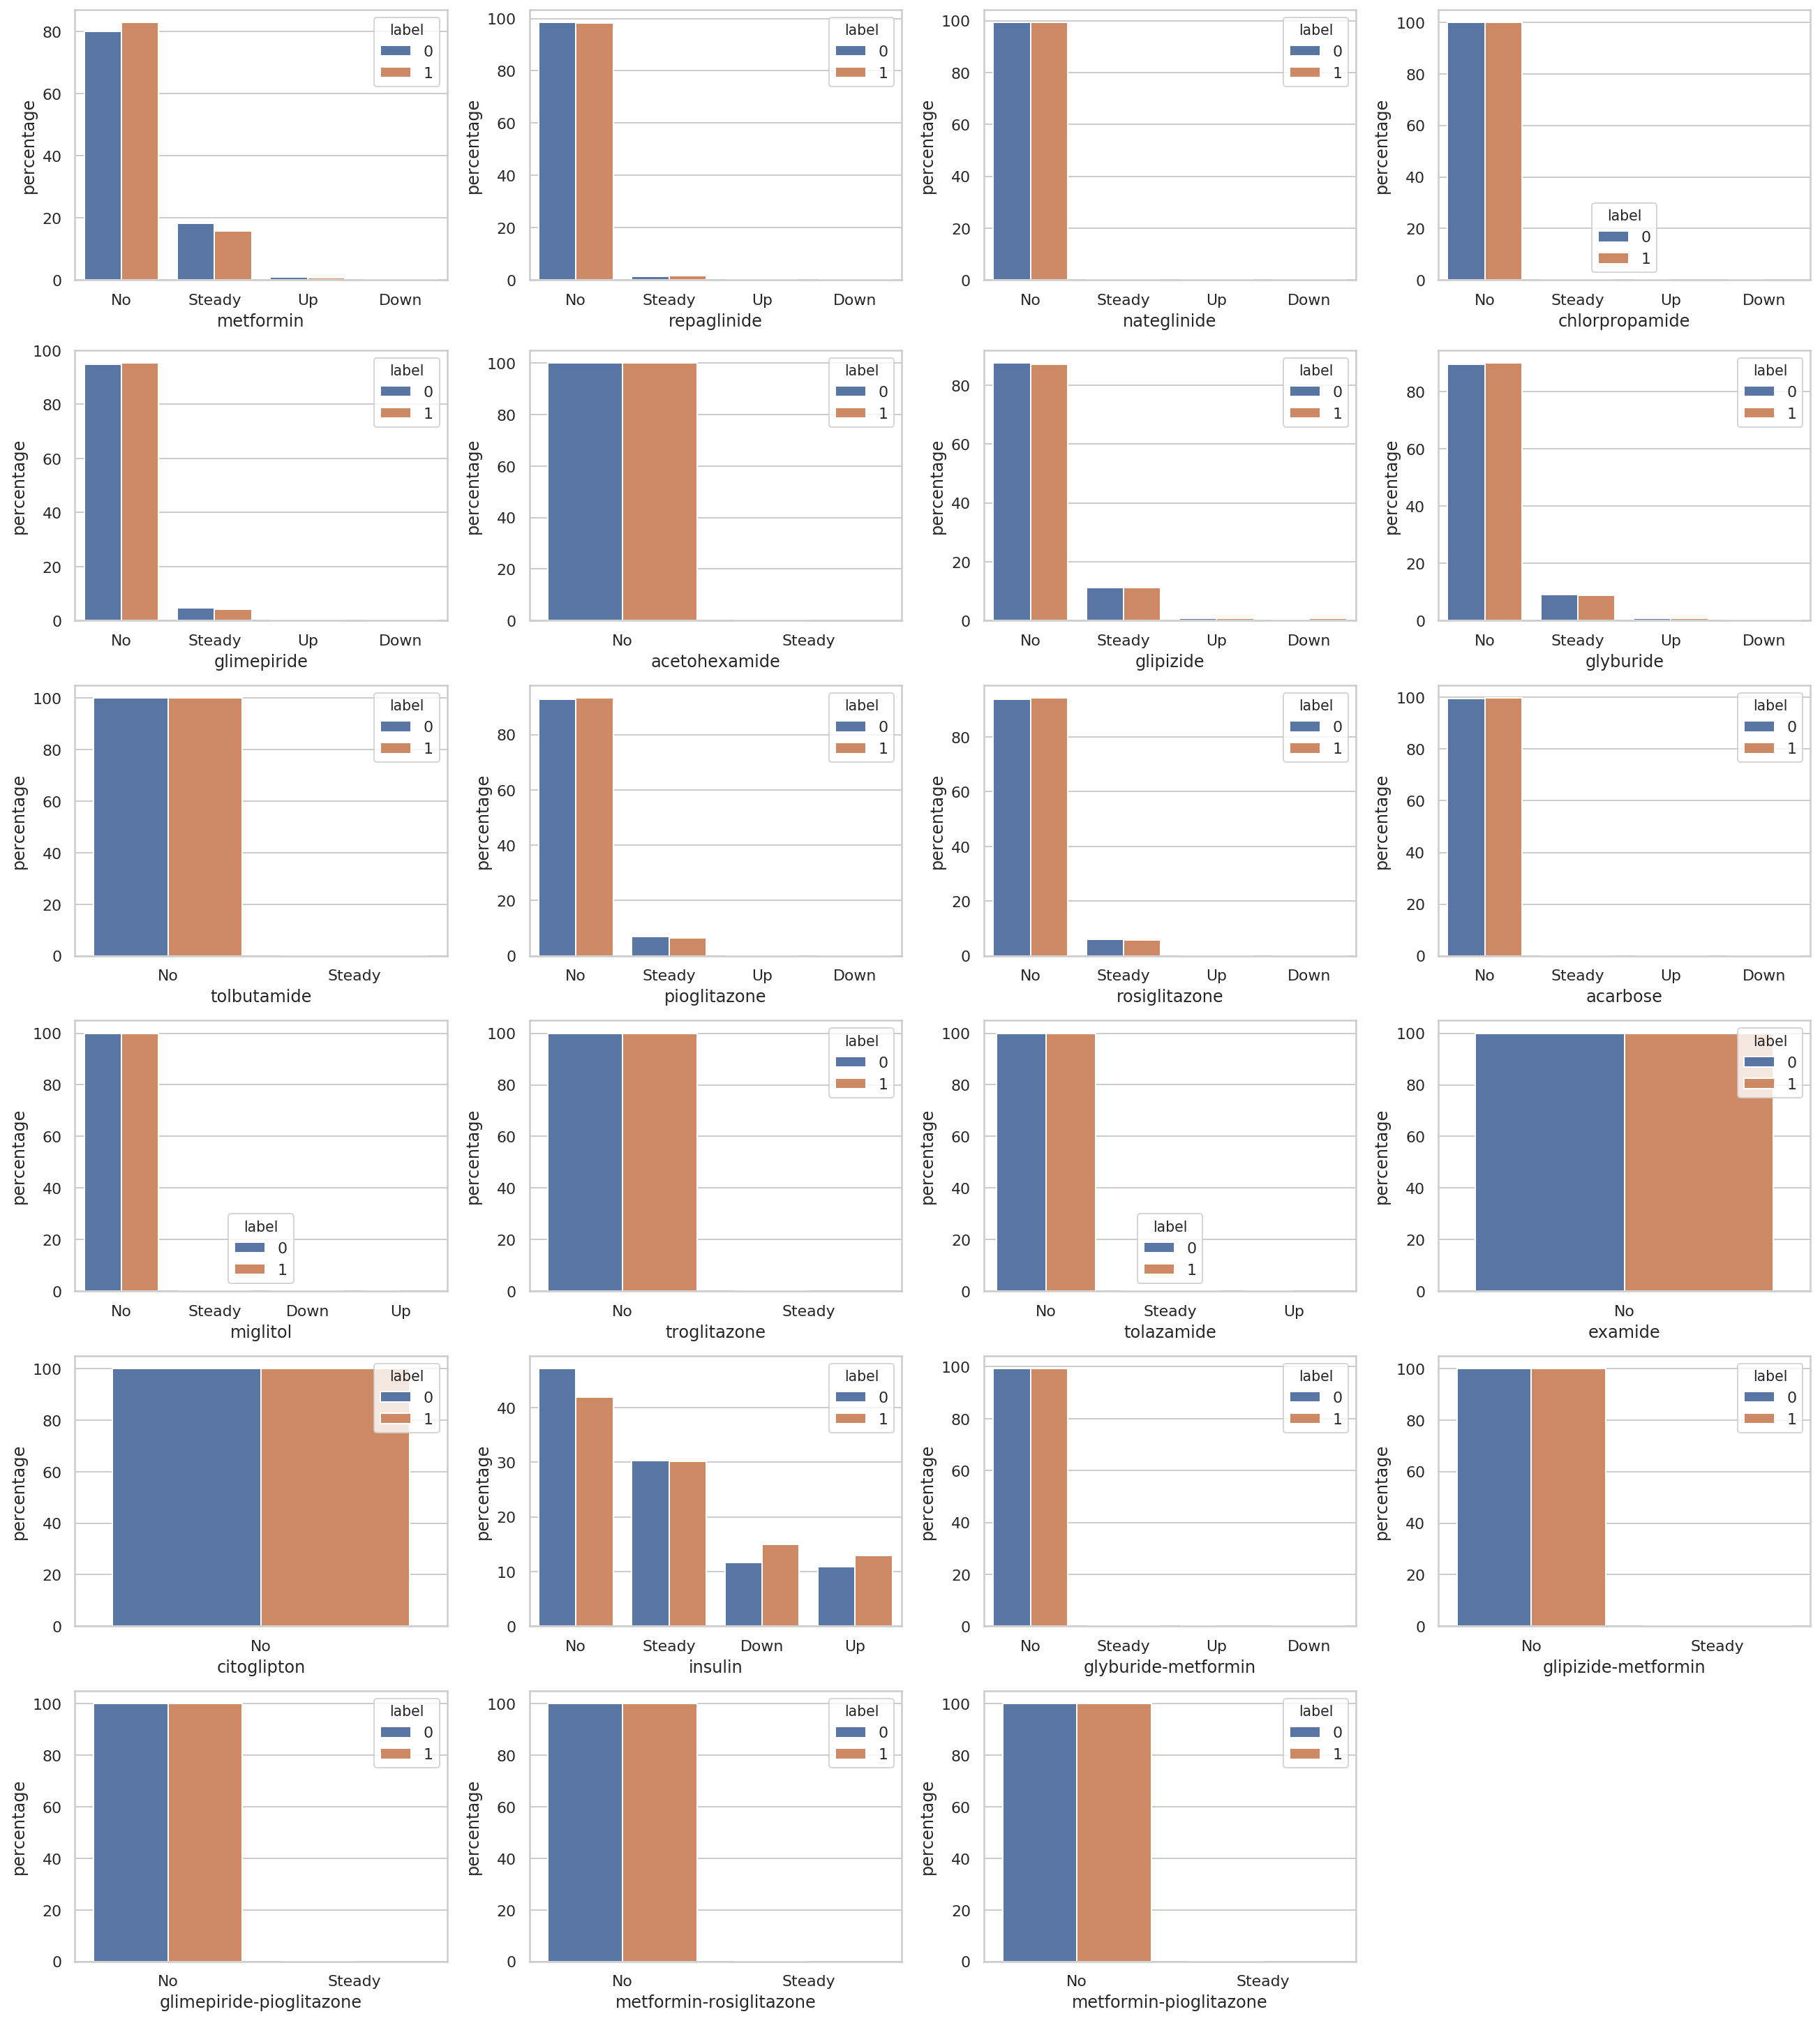

In [61]:
fig, axs = plt.subplots(nrows=6, ncols=4, constrained_layout=True)
fig.delaxes(axs[5,3])

fig.set_size_inches(18, 20)
for y in range(0,6):
    for x in range(0,4):
        if x + 4 * y == len(all_medicaments):
            break
        barplot_per_classes(df, all_medicaments[x + 4 * y], 'label', ax=axs[y][x])

From plots above, we can see that `citoglipton` and `examide` does contain only one value. Those attributes can be dropped because they do not contain any information for classification. In general, a lot of those attributes contain one major value (in all cases it is value `No`). That means most of the medicaments are not used for diabetes treatment. The medicament `insulin` is the only one that we can do some observations to final prediction - and we can see that dosages of insulin are more experimental in patients that will be readmitted. It is hard to say whether other medicaments attributes can help in predicting early readmission. On the other hand, we can also loose the important information in edge cases by dropping those attributes.

#### change

*Change of medications* - Indicates if there was a change in diabetic medications (either dosage or generic name).

Values: `change` and `no change`.

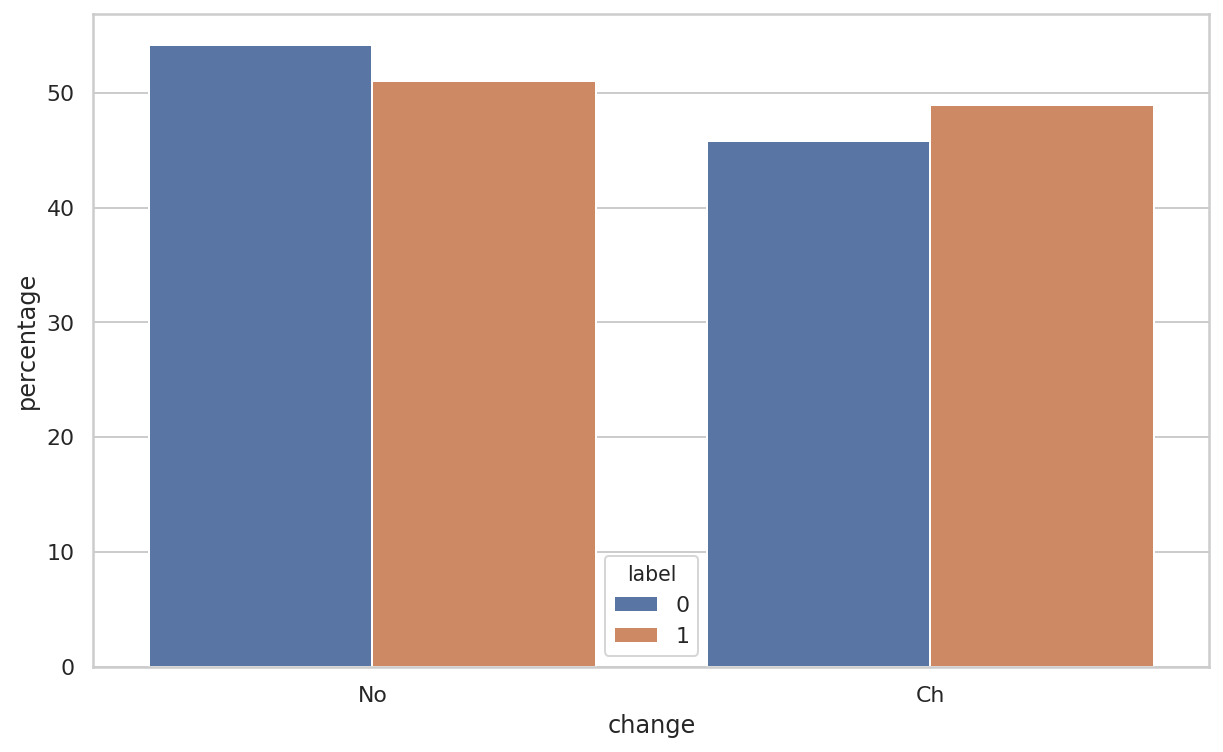

In [62]:
barplot_per_classes(df, 'change', 'label')

#### max_glu_serum

*Glucose serum test result* - Indicates the range of the result or if the test was not taken.

Values:
* `>200`,
* `>300`,
* `normal`,
* `none` if not measured.

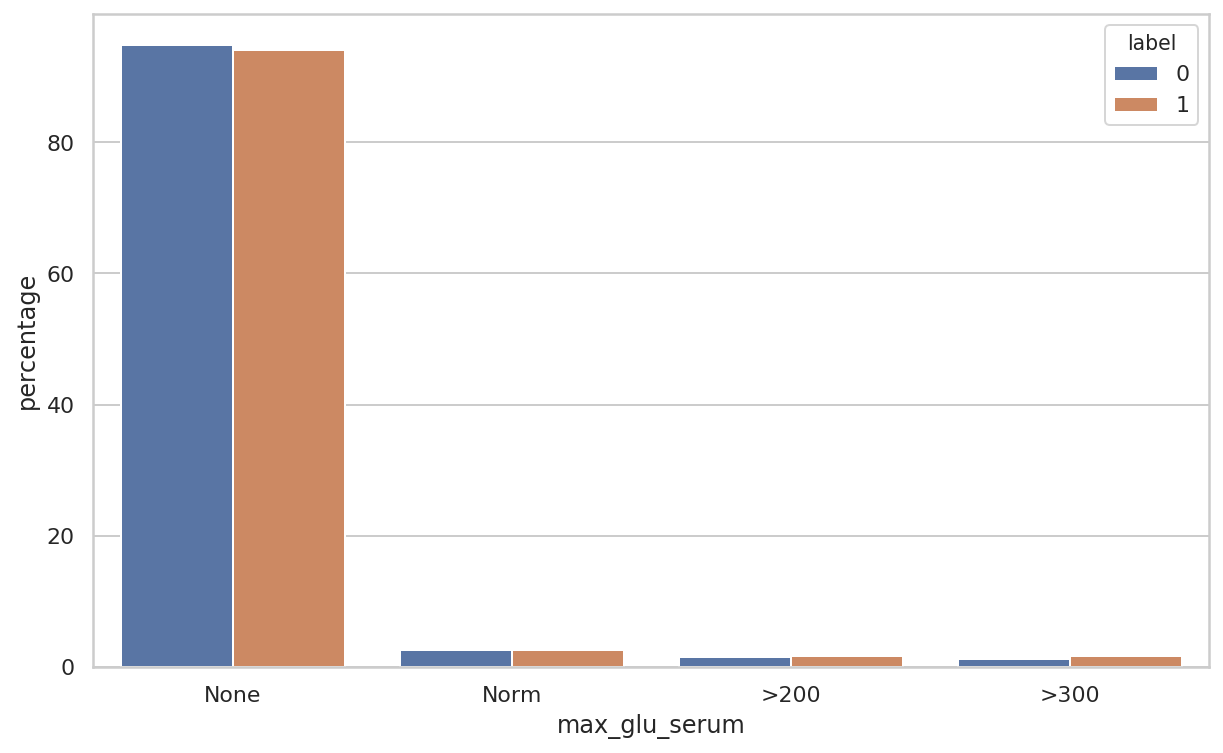

In [63]:
barplot_per_classes(df, 'max_glu_serum', 'label')

#### A1Cresult

Indicates the range of the result or if the test was not taken.

Values:
* `>8` if the result was greater than 8%,
* `>7` if the result was greater than 7% but less than 8%,
* `normal` if the result was less than 7%,
* `none` if not measured.

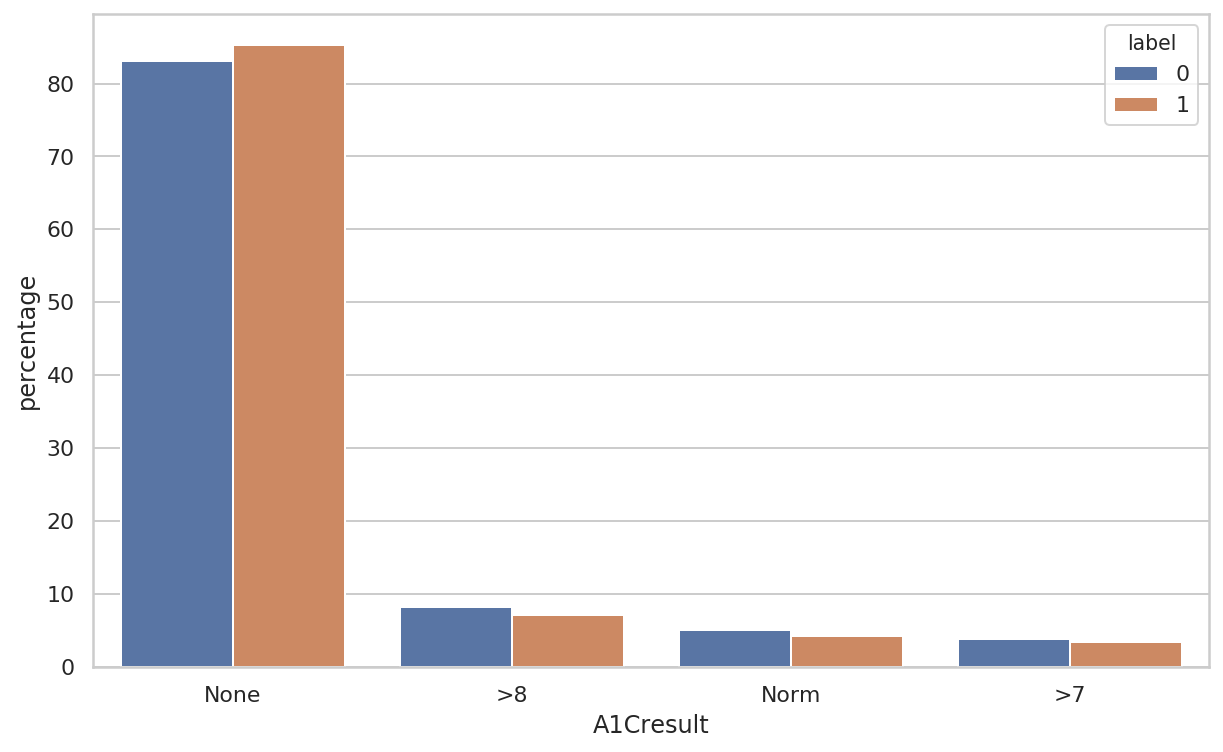

In [64]:
barplot_per_classes(df, 'A1Cresult', 'label')

#### diabetesMed

Indicates if there was any diabetic medication prescribed.

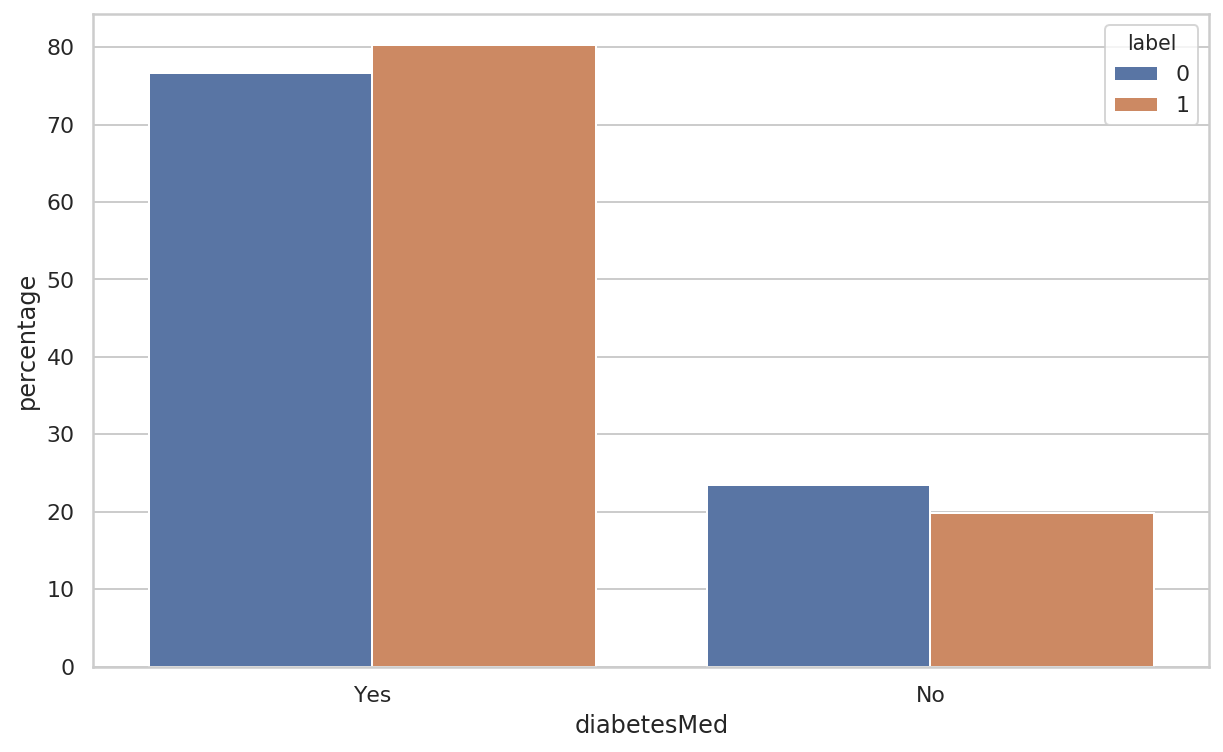

In [65]:
barplot_per_classes(df, 'diabetesMed', 'label')

### Feature engineering

In this section, we will create also some additional features/attributes from the data. Those attributes can aggregate the information and help in prediction.

#### number of visits

Sum of values in attributes: `number_emergency`, `number_outpatient`, `number_inpatient`

In [66]:
df['visits_sum'] = df.apply(
    lambda x: x['number_emergency'] + x['number_outpatient'] + x['number_inpatient'], axis=1
)

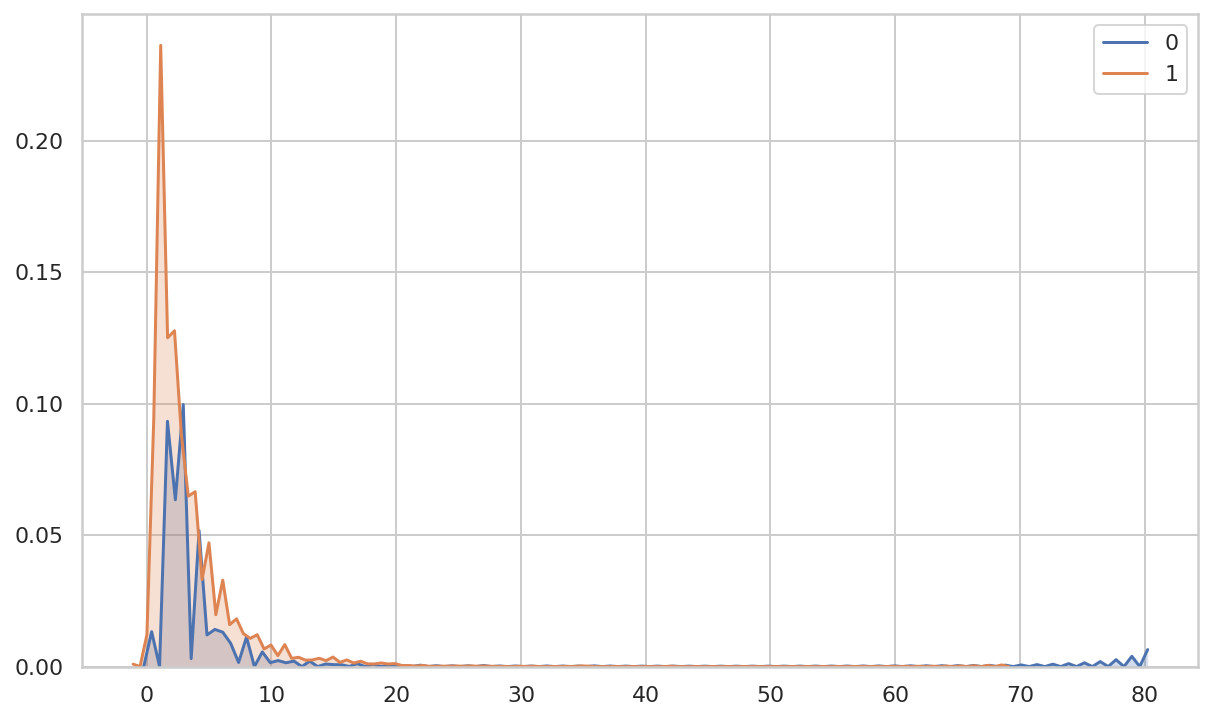

In [67]:
kdeplot_per_classes(df, 'visits_sum', 'label')

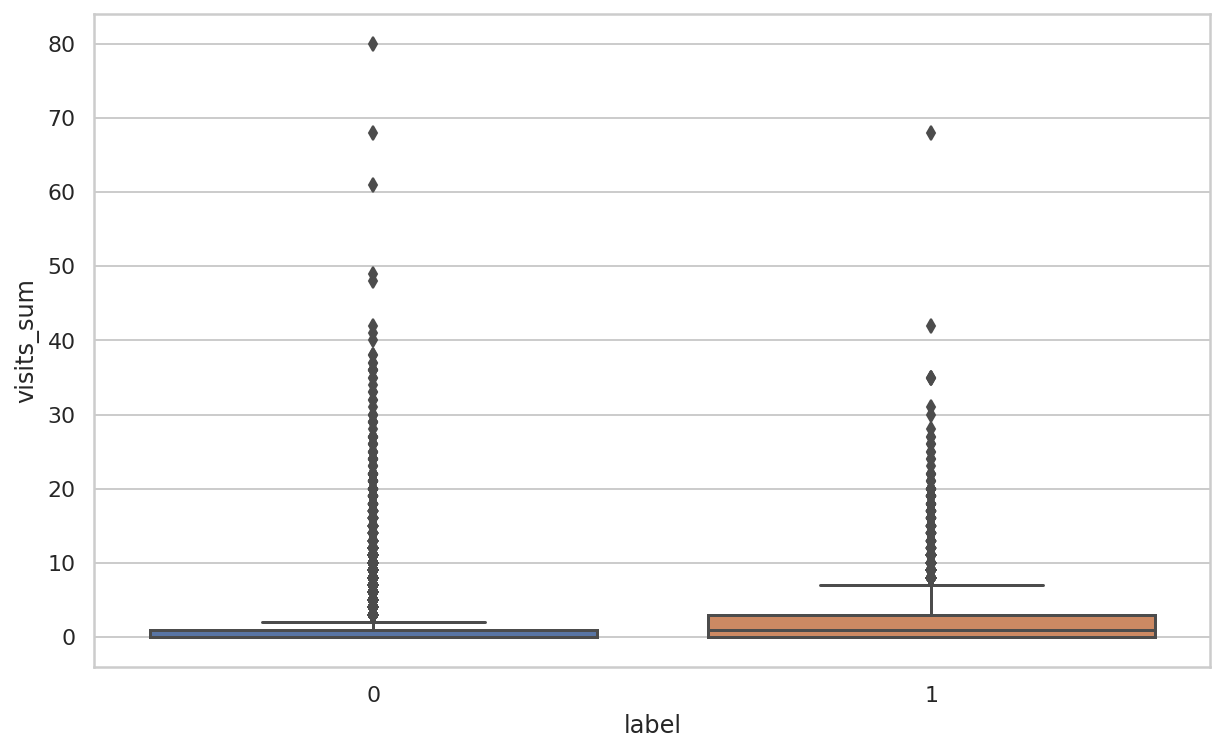

In [68]:
boxplot_per_classes(df, 'visits_sum', 'label')

From the plots above, we can see that there is a difference between readmitted and not readmitted patients in summary of their visits in preceding year. This attribute can be used in prediction.

#### number of medicaments changes

Number of changes provided through all medicaments (23 features).

In [69]:
col_name = 'number_medicaments_changes'
df[col_name] = 0

for medicament in all_medicaments:
    df[col_name] = df.apply(
        lambda x: x[col_name] + 1 if x[medicament] not in ['No', 'Steady'] else x[col_name], axis=1
    )

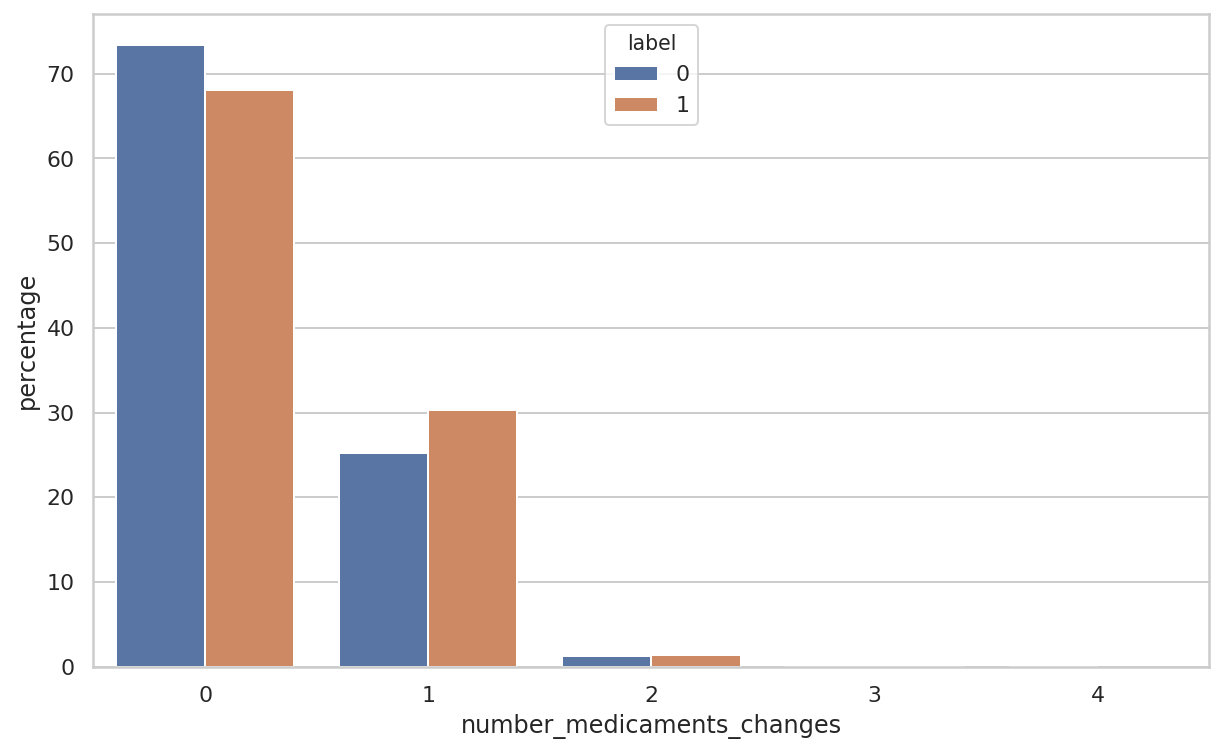

In [70]:
barplot_per_classes(df, 'number_medicaments_changes', 'label')

It's look like number of changes in medications (experimenting) can be interesting for prediction of patient's readmission. We will use this attribute in prediction to check its usefulness.

#### number of medicaments

Number of medicaments provided to patient (23 features).

In [71]:
df['number_medicaments'] = df[all_medicaments].apply(
    lambda y: y.apply(lambda x: np.sum(0 if x == 'No' else 1)), axis=1
).apply(np.sum, axis=1)

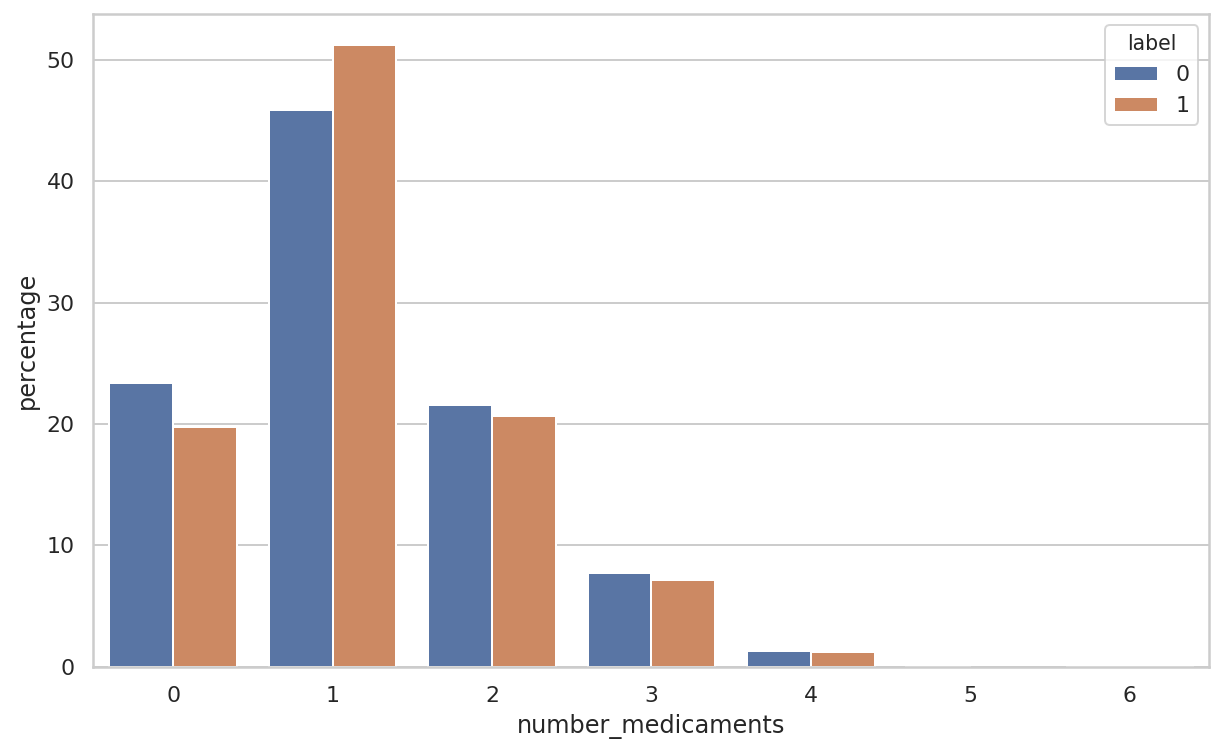

In [72]:
barplot_per_classes(df, 'number_medicaments', 'label')

At first sight, number of medicaments prescribed to patient can be helpful in prediction of patient's readmission.

### Pairplot of numerical attributes

Let's draw also pariplot of numerical attributes to see the impact of two values on predicted class.

In [74]:
columns =  [
    'num_medications', 'num_lab_procedures', 'num_procedures', 'time_in_hospital',
    'number_diagnoses', 'number_inpatient', 'number_outpatient', 'number_emergency',
    'visits_sum', 'age_middle_value', 'number_medicaments', 'number_medicaments_changes'
]
# sns.pairplot(df, vars=columns, hue='label');

### Correlation for numetrical attributes

Correlation heatmap showed those correlations:
* weak correlation between `num_medications` and `num_procedures`
* weak correlation between: `num_medications` and `time_in_hospital`, `num_procedures` and `time_in_hospital` - the longer patient stay in hospital, the more procedures/medications are provided to him
* weak correlation between `number_medicaments` and `number_medicaments_changes`
* moderate correlations between `visits_sum` and attributes `number_inpatient`, `number_outpatient` and `number_emergency`, but because the `visits_sum` is created as sum of the next three, it is not interesting information.

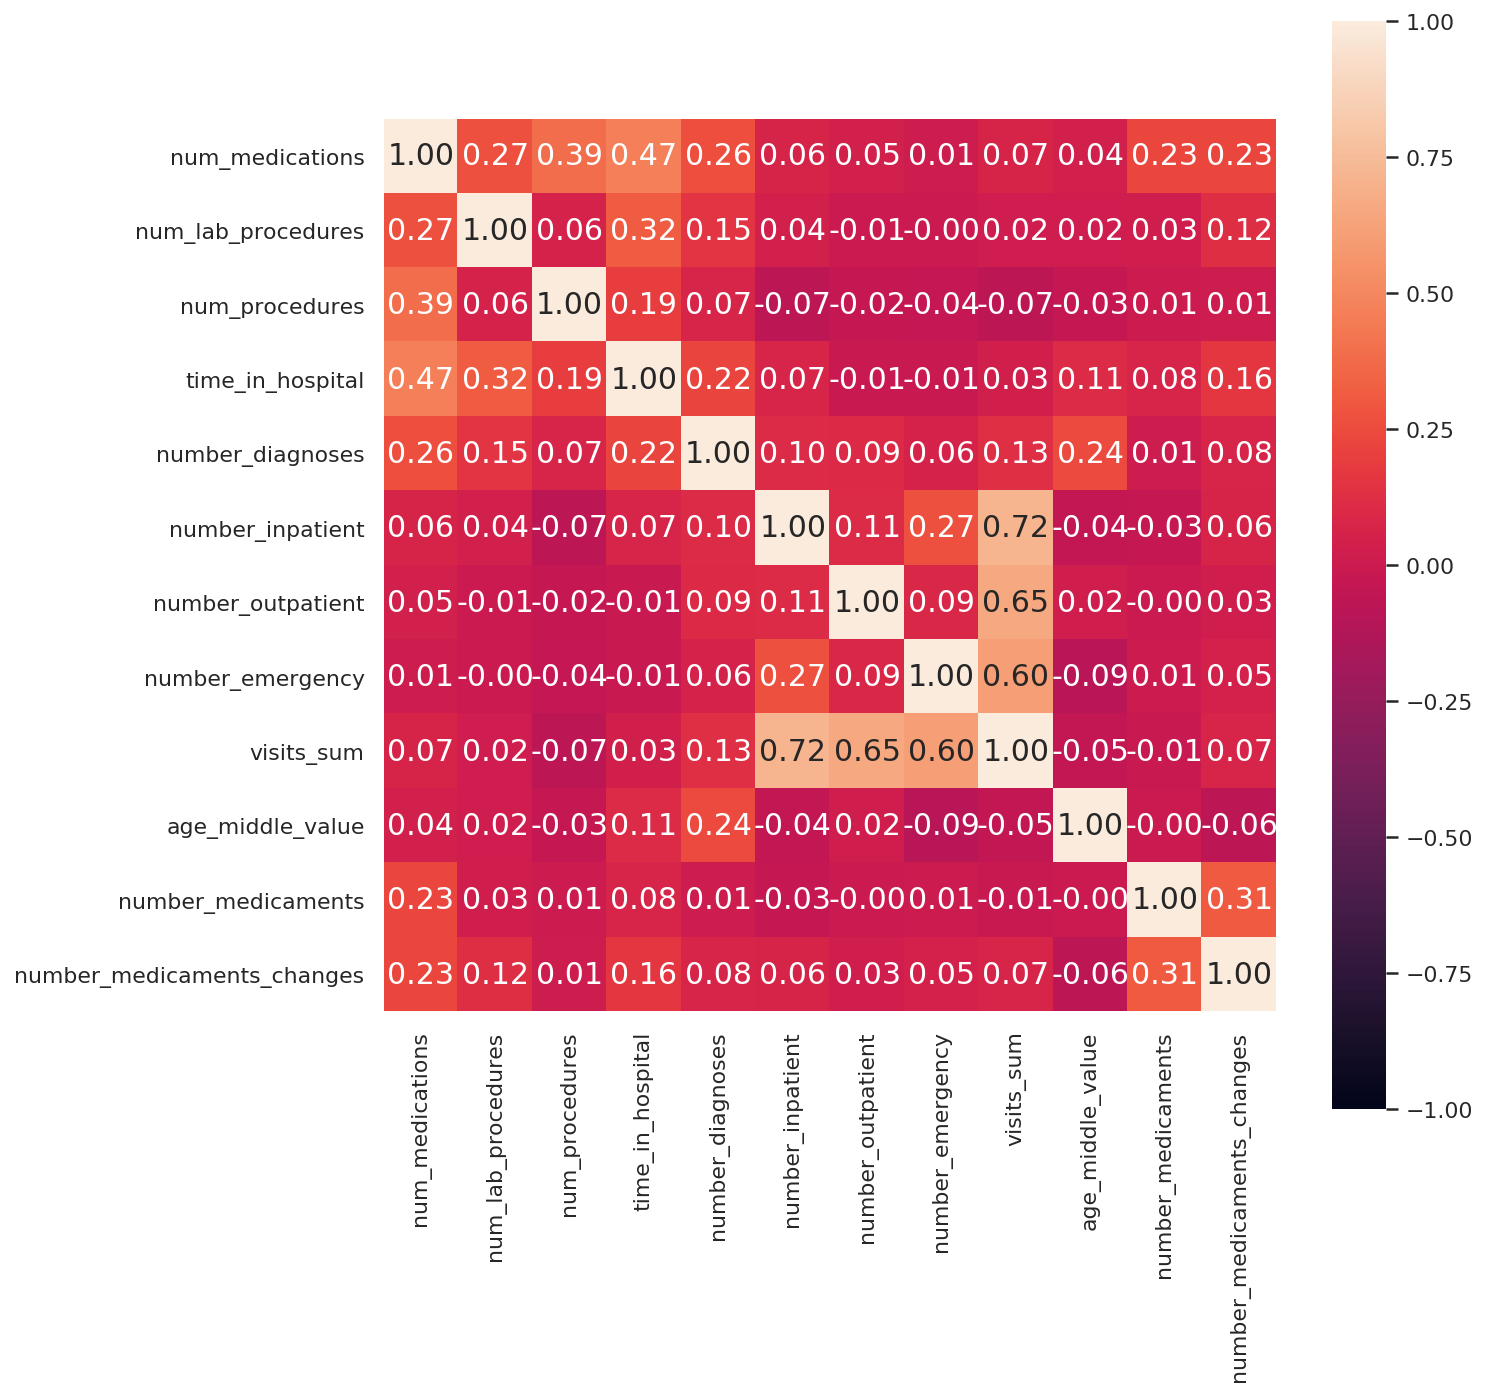

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[columns].corr(), annot=True, fmt=".2f", vmin=-1.0, vmax=1.0, square=True);

### Conclusion

In this jupyter notebook, dataset of diabetes patients readmission [1] was analysed. Descriptive analysis of whole dataset was performed, after also each attribute one-by-one was analysed according to its type.

Results of analysis showed the problems in the data that should be handled in preprocessing phase (e.g. missing values, useless attributes, etc.).

Analysis of attributes and new features creation (feature engineering) will help us in choosing/suspending features for model choosing and prediction phase. Some of the attributes did not show significant differences across classes in analysis, but the final results about their usefulness in prediction will be revealed in model feature importance later.

### References
[1] Strack, Beata & Deshazo, Jonathan & Gennings, Chris & Olmo Ortiz, Juan Luis & Ventura, Sebastian & Cios, Krzysztof & Clore, John. (2014). Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records. BioMed research international. 2014. 